# Grab AI Challege - Computer Vision

## Automated Car Detail Recognition

__PROBLEM STATEMENT__:<br> 
Given a dataset of distinct car images, can we automatically recognize the car model and make? <br>

_Larger Objective_: <br>
How can we help passengers find their rides quicker and in turn increase earning opportunities for our driver-partners by automating the process of digitizing & understanding imagery on the highest possible quality?

Data set: Cars Dataset from Stanford University <br>
Details: 18,185 images of 196 classes of cars <br>
Training Images: 8,144 <br>
Testing Images: 8,041 <br>
Classes: Make, Model, Year (e.g., 2012 Tesla model S or 2012 BMW M3 coupe)<br>

The solution is inspired by the Object Detection Technique discussed in the Fast.ai lesson by Jeremy Howard. <br>
(Link: https://www.youtube.com/watch?v=Z0ssNAbe81M) <br>
Additional insight was derived from Francesco Pochetti on his implementation on Chest Radiographs <br>
(Link: http://francescopochetti.com/detecting-pneumonia-in-chest-radiographs-with-fast-ai/)

## Import needed FastAI and Python Libraries

In [1]:
# import the needed jupyter magic lines
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# import FastAI library
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

# import other Python Libraries
import pandas as pd
import numpy as np
from scipy.special import expit

## Download and extract Stanford Cars Dataset

In [ ]:
# Download the dataset
# dataset_link = 'http://imagenet.stanford.edu/internal/car196/car_ims.tgz'
# labels_link = 'http://imagenet.stanford.edu/internal/car196/cars_annos.mat'
# save_dir = '/data/home/franciscorpuz/notebooks/fastai07/fastai/courses/dl2/data/cars/'
# !wget -P $save_dir -O cars_ims.tgz $dataset_link

# # Extract the dataset
# car_dataset = save_dir + 'cars_ims.tgz'
# print("save_dir: " + save_dir)
# print("car_dataset: " + car_dataset)
# !tar -C $save_dir -zxvf $car_dataset


Here, since the annotations are in the Matlab *.mat* format, it was extracted and exported to CSV for easier data manipulations. The CSVs (comma-separated values) are then imported as Pandas dataframe

In [3]:
# Read the CSVs into their corresponding dataframes
annotations = pd.read_csv("data/cars/annotations.csv")
car_classes = pd.read_csv("data/cars/car_classes.csv", header=None)
                          
# Separate the annotation data into the training and test sets
annotations_train = annotations[annotations['is_test'] == 1]
annotations_test = annotations[annotations['is_test'] != 1]

# Rename the column name in the model dataframe
car_classes.columns = ["model"]

# Reset dataframe class index to '1' to be consistent with source dataset
car_classes.index += 1

In [ ]:
annotations_train.head()
annotations_train.to_csv('annotations_train.csv')

Convert the dataframe into a dictionary format suitable for training: <br>

In [4]:
# Convert the dataframe into a dictionary format suitable for training: 

categories = collections.defaultdict(lambda:[])
for rows in car_classes.itertuples():
    categories[rows[0]] = rows[1]

annotations_train_dict = collections.defaultdict(lambda:[])
for rows in annotations_train.itertuples():
    bb = np.array([rows[2], rows[3], rows[4], rows[5]])
    annotations_train_dict[rows[0]] = [rows[1], bb, rows[6]]

In [5]:
# Some utility functions from the FastAI library v.0.7 to display images and bounding boxes
# Functions were edited to accommodate the format structure of the Stanford Cars dataset

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_im(im, b, i):
    ax = show_img(im, figsize=(16,8))
#     for b,c in ann:
#         b = bb_hw(b)
    draw_rect(ax, b)
    draw_text(ax, b[:2], categories[annotations_train_dict[i][2]], sz=16)
        
def draw_idx(i):
#     im_a = trn_anno[i]
    b = annotations_train_dict[i][1]
    IMG_PATH = Path('/data/home/franciscorpuz/notebooks/fastai07/fastai/courses/dl2/data/cars/')
    file_name = IMG_PATH/annotations_train_dict[i][0]
    im = open_image(file_name)
#     im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, b, i)
    
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))
    

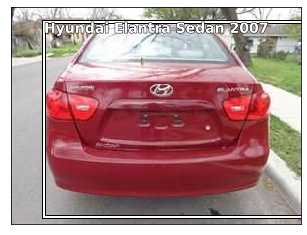

In [6]:
# Sample an image file in the dataset

index = np.random.choice(list(annotations_train_dict.keys()))
IMG_PATH = Path('/data/home/franciscorpuz/notebooks/fastai07/fastai/courses/dl2/data/cars/')
file_name = IMG_PATH/annotations_train_dict[index][0]
im = open_image(file_name)

ax = show_img(im)
b = annotations_train_dict[index][1]
draw_rect(ax, b)
draw_text(ax, b[:2], categories[annotations_train_dict[index][2]])


(768, 1024, 3)
(375, 500, 3)
(318, 520, 3)
(360, 640, 3)
(375, 500, 3)
(492, 786, 3)
(194, 259, 3)
(89, 120, 3)
(960, 1280, 3)
(167, 217, 3)
(255, 320, 3)
(378, 630, 3)


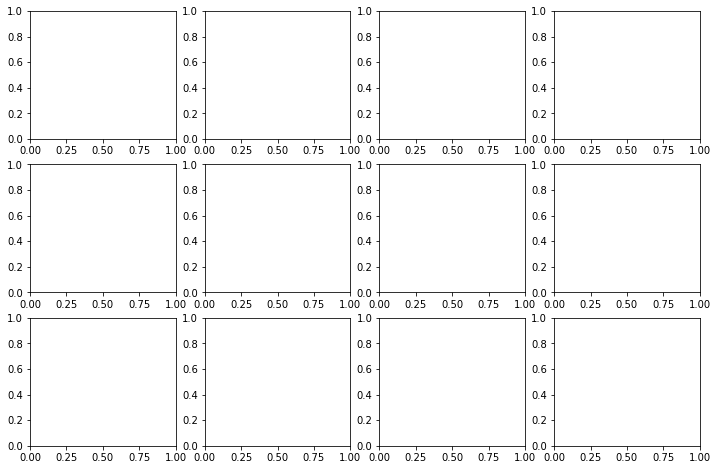

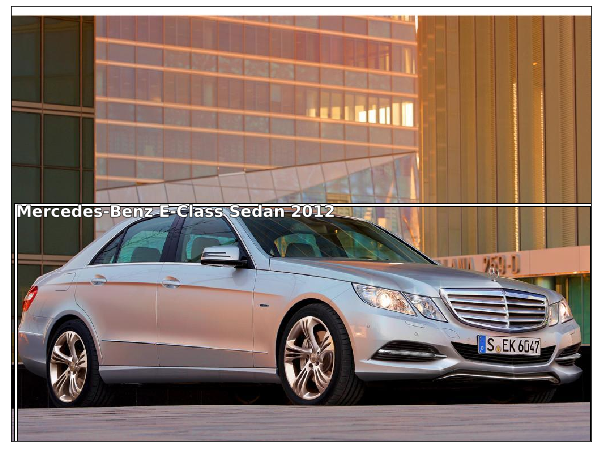

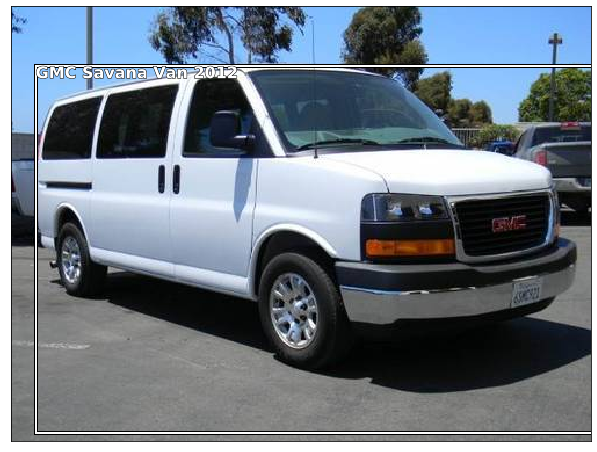

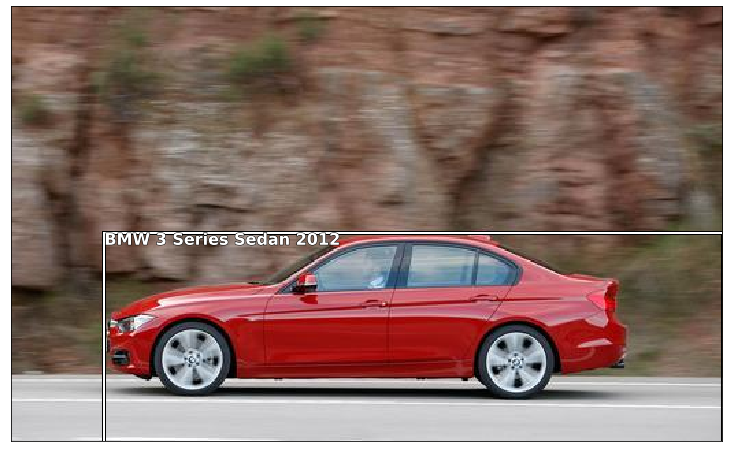

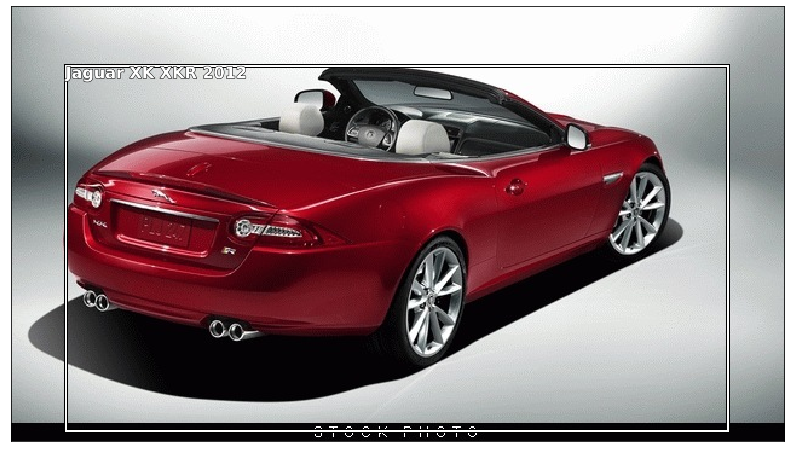

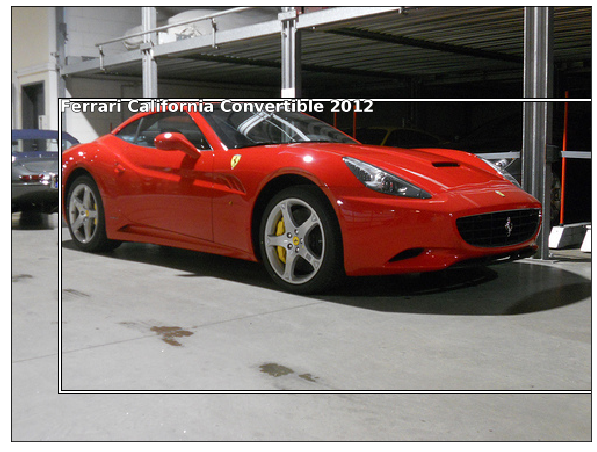

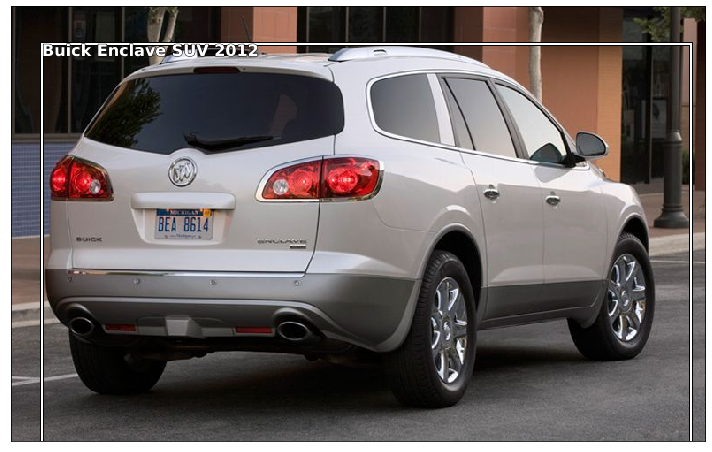

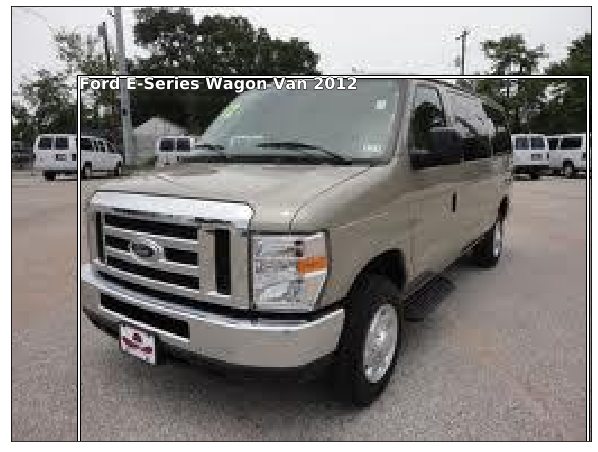

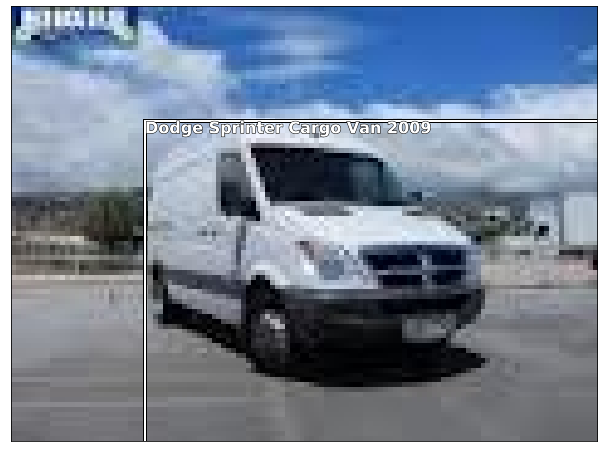

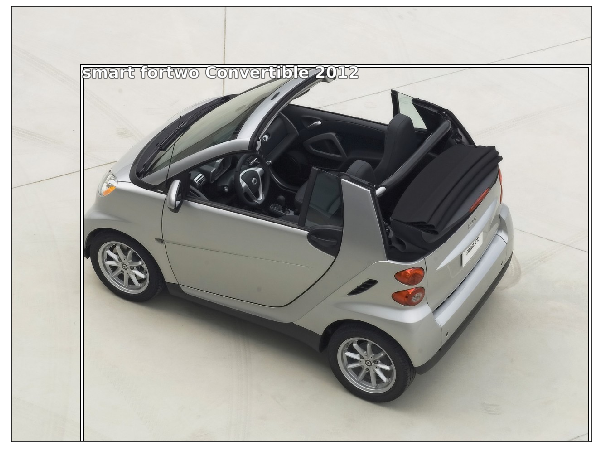

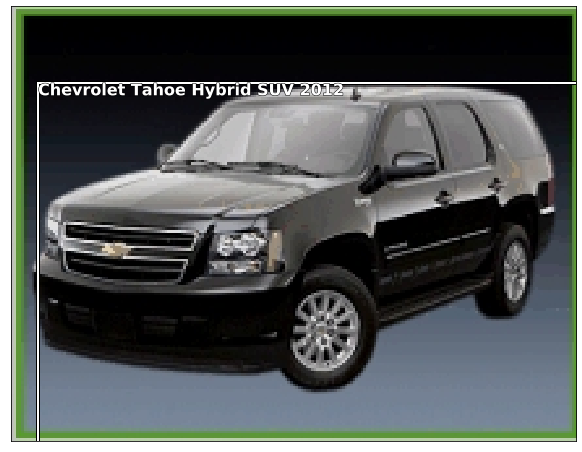

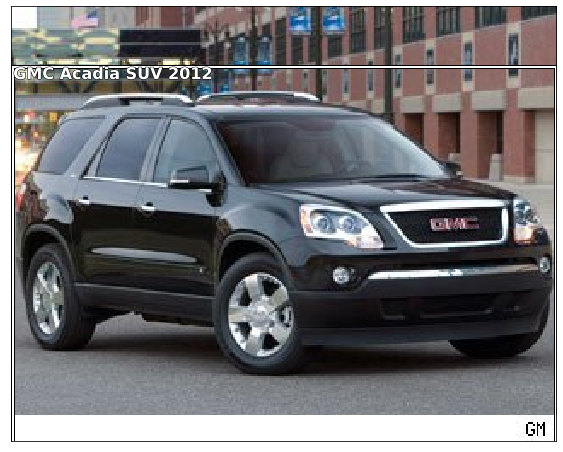

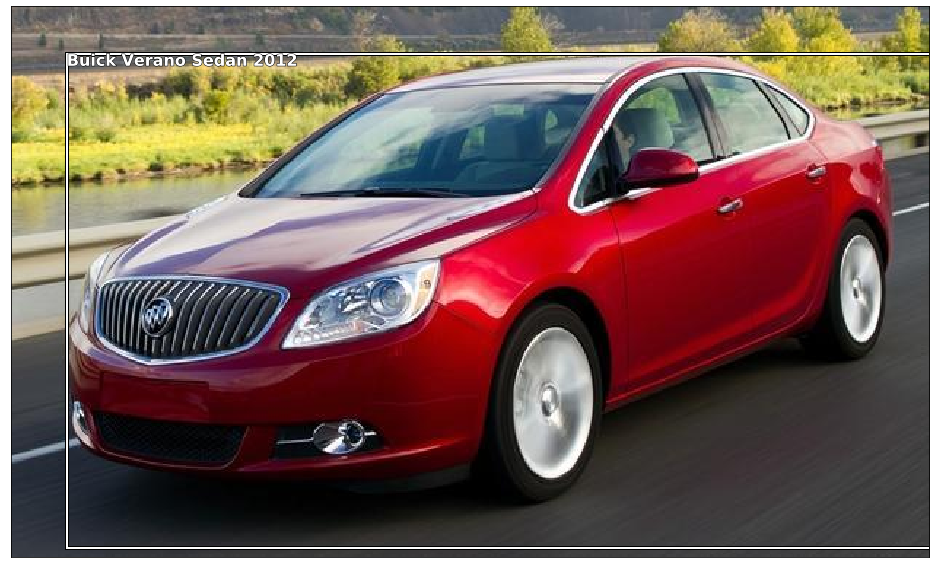

In [9]:
# View sample images and corresponding bounding boxes and labels

fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for _,ax in enumerate(axes.flat):
    index = np.random.choice(list(annotations_train_dict.keys()))
    draw_idx(index)
    
plt.tight_layout()

In [8]:
CAT_CSV = IMG_PATH/'filenames.csv'
BB_CSV = IMG_PATH/'bb.csv'

In [10]:
bb_csv_df = pd.DataFrame(columns=['fn','bbox'])
cat_csv_df = pd.DataFrame(columns=['fn','cat'])

for rows in annotations_train.itertuples():
    bb = np.array([rows[2], rows[3], rows[4], rows[5]])
    bb_string = ' '.join(str(p) for p in bb)
    bb_csv_df = bb_csv_df.append({'fn':rows[1], 'bbox': bb_string}, ignore_index=True)
    cat_csv_df = cat_csv_df.append({'fn':rows[1], 'cat': rows[6]}, ignore_index=True)


In [ ]:
bb_csv_df.to_csv(BB_CSV, index=False)
cat_csv_df.to_csv(CAT_CSV, index=False)

BB_CSV.open().readlines()[:5]
CAT_CSV.open().readlines()[:5]

## Create the Network Architecture

In [11]:
# Creating the network

f_model=resnet34
sz = 512
bs = 8

# tfm_y=TfmType.COORD
augs = [RandomFlip(),
        RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
        RandomLighting(0.05,0.05, tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, aug_tfms=augs, crop_type=CropType.NO)
# tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(IMG_PATH, "", BB_CSV, tfms=tfms, continuous=True, bs=bs)

learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 512, 512]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 256, 256]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_sha

In [12]:
# Define the number of neurons that would comprise the new head of the network
# top_archi_input = 512*16*16
top_archi_input = 25088 # <----- tested to be working

In [13]:
# Creating the network
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(cat_csv_df))

augs = [RandomFlip(),
        RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
        RandomLighting(0.05,0.05, tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)

In [15]:
# Integrate the car classes information to the network along with the bounding box information

md_box = ImageClassifierData.from_csv(IMG_PATH, "", BB_CSV, tfms=tfms, bs=bs, continuous=True, val_idxs=val_idxs)
md_class = ImageClassifierData.from_csv(IMG_PATH, "", CAT_CSV, tfms=tfms_from_model(f_model, sz))

trn_ds = ConcatLblDataset(md_box.trn_ds, md_class.trn_y)
val_ds = ConcatLblDataset(md_box.val_ds, md_class.val_y)

md_box.trn_dl.dataset = trn_ds
md_box.val_dl.dataset = val_ds

[ 19.  18. 222. 130.]
[ 18.  19. 221. 129.]
[ 19.  19. 222. 129.]
[ 18.  18. 222. 131.]
[ 19.  20. 221. 128.]
[ 19.  20. 221. 128.]
[ 19.  20. 221. 128.]
[ 13.  16. 222. 131.]
[ 19.  20. 221. 128.]


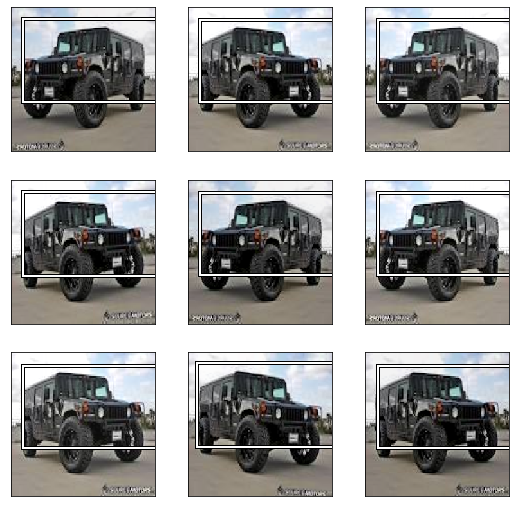

In [16]:
# Quick Check on the results of the data augmentation

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(IMG_PATH, "", BB_CSV, tfms=tfms, continuous=True, bs=4)

idx=0
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = to_np(y[idx])
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [23]:
# Redefine the network head architecture to accommodate neurons for classification and bounding boxes

head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(top_archi_input,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(categories)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md_box, models)
learn.opt_fn = optim.Adam
# learn.crit = nn.L1Loss()

## Loss definitions (from FastAI)

In [24]:
# a scalar factor computed from the ratio of the L1 loss and the Cross Entropy Loss
scalar = 30

def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*scalar

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]


## Training the Network

  2%|▏         | 2/101 [00:01<01:48,  1.10s/it, loss=238]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<01:02,  1.54it/s, loss=237]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:03<01:06,  1.43it/s, loss=237]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:36,  2.52it/s, loss=238]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:03<00:29,  3.02it/s, loss=238]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:04<00:19,  4.52it/s, loss=238]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:04<00:18,  4.70it/s, loss=237]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:42,  2.00it/s, loss=237]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:06<00:36,  2.31it/s, loss=237]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:06<00:21,  3.81it/s, loss=237]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:06<00:16,  4.87it/s, loss=237]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:06<00:14,  5.57it/s, loss=237]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:34,  2.24it/s, loss=236]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:08<00:22,  3.28it/s, loss=236]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:08<00:16,  4.30it/s, loss=236]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:08<00:15,  4.74it/s, loss=236]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:08<00:13,  5.13it/s, loss=235]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:10<00:37,  1.82it/s, loss=235]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:10<00:20,  3.13it/s, loss=233]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:10<00:13,  4.71it/s, loss=233]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:11<00:11,  5.51it/s, loss=232]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:12<00:23,  2.57it/s, loss=232]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:12<00:19,  2.98it/s, loss=231]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:13<00:15,  3.73it/s, loss=230]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:13<00:12,  4.41it/s, loss=230]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:13<00:10,  5.39it/s, loss=229]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:15<00:24,  2.14it/s, loss=227]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:15<00:14,  3.50it/s, loss=225]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:15<00:10,  4.45it/s, loss=222]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:15<00:08,  5.47it/s, loss=219]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:16<00:16,  2.78it/s, loss=217]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:16<00:12,  3.44it/s, loss=213]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:17<00:08,  4.77it/s, loss=210]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:17<00:07,  5.23it/s, loss=209]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:17<00:08,  4.38it/s, loss=207]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:18<00:10,  3.47it/s, loss=205]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:19<00:09,  3.65it/s, loss=204]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:19<00:05,  5.31it/s, loss=204]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:20<00:07,  3.99it/s, loss=204]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:21<00:14,  2.03it/s, loss=204]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:21<00:07,  3.49it/s, loss=209]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:21<00:04,  5.02it/s, loss=221]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:22<00:06,  3.16it/s, loss=228]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 82%|████████▏ | 83/101 [00:24<00:09,  1.85it/s, loss=273]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:24<00:05,  3.10it/s, loss=352]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:24<00:03,  4.61it/s, loss=520]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


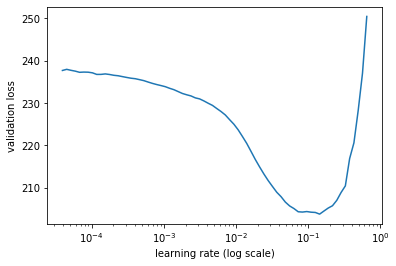

In [25]:
# Finding the appropriate learning rate for the training
learn.lr_find()
learn.sched.plot()

In [26]:
# Based on the curve above, select the point about 2 magnitudes from the minima
# Minima is around, 10e-1, select 10e-3 as the learning rate

lr = 10e-3
learn.fit(lr, 3, cycle_len=3, use_clr=(32,10))

  2%|▏         | 2/101 [00:01<01:56,  1.18s/it, loss=240] 

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:18,  1.24it/s, loss=237]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:03<00:41,  2.24it/s, loss=235]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:33,  2.71it/s, loss=234]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:03<00:24,  3.71it/s, loss=232]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:04<00:19,  4.43it/s, loss=231]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:04<00:19,  4.43it/s, loss=230]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:04<00:22,  3.83it/s, loss=229]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:26,  3.16it/s, loss=228]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:32,  2.58it/s, loss=226]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:05<00:28,  2.91it/s, loss=225]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:06<00:24,  3.31it/s, loss=222]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:06<00:18,  4.23it/s, loss=218]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:24,  3.10it/s, loss=214]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:08<00:24,  3.09it/s, loss=209]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:08<00:16,  4.40it/s, loss=205]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:09<00:11,  6.08it/s, loss=200]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:09<00:21,  3.16it/s, loss=198]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:10<00:27,  2.47it/s, loss=197]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:10<00:18,  3.58it/s, loss=194]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:10<00:14,  4.44it/s, loss=191]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:11<00:19,  3.28it/s, loss=190]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:11<00:18,  3.34it/s, loss=187]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:12<00:20,  2.91it/s, loss=186]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:12<00:16,  3.51it/s, loss=184]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:13<00:12,  4.46it/s, loss=182]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:13<00:13,  4.06it/s, loss=179]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:14<00:15,  3.34it/s, loss=178]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:14<00:18,  2.89it/s, loss=178]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:15<00:32,  1.59it/s, loss=177]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:16<00:17,  2.68it/s, loss=174]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:16<00:10,  4.33it/s, loss=170]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:17<00:16,  2.53it/s, loss=169]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:17<00:12,  3.23it/s, loss=167]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:17<00:09,  4.07it/s, loss=165]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:08,  4.12it/s, loss=164]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:18<00:08,  4.16it/s, loss=163]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:19<00:13,  2.58it/s, loss=162]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:20<00:10,  3.02it/s, loss=160]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:20<00:06,  4.67it/s, loss=158]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:20<00:05,  5.50it/s, loss=158]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 74%|███████▍  | 75/101 [00:21<00:06,  4.26it/s, loss=157]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 76%|███████▌  | 77/101 [00:21<00:05,  4.44it/s, loss=155]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 77%|███████▋  | 78/101 [00:22<00:05,  4.44it/s, loss=155]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:22<00:04,  5.08it/s, loss=154]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:24<00:11,  1.69it/s, loss=153]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 83%|████████▎ | 84/101 [00:24<00:05,  2.88it/s, loss=152]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:25<00:03,  4.44it/s, loss=150]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 89%|████████▉ | 90/101 [00:26<00:03,  3.49it/s, loss=149]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:26<00:02,  3.69it/s, loss=147]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 94%|█████████▍| 95/101 [00:27<00:01,  4.57it/s, loss=146]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:27<00:00,  4.42it/s, loss=145]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 97%|█████████▋| 98/101 [00:27<00:00,  3.44it/s, loss=145]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]        

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:32,  1.31s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:24,  1.02s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  15%|█▌        | 4/26 [00:02<00:17,  1.28it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  27%|██▋       | 7/26 [00:02<00:08,  2.26it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  38%|███▊      | 10/26 [00:03<00:05,  2.84it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  42%|████▏     | 11/26 [00:03<00:04,  3.60it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  50%|█████     | 13/26 [00:04<00:03,  4.29it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  54%|█████▍    | 14/26 [00:04<00:02,  4.91it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  65%|██████▌   | 17/26 [00:04<00:01,  6.28it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:01,  4.96it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.79it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:05<00:02,  2.87it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.72it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  3.70it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

epoch      trn_loss   val_loss   detn_acc   detn_l1        
    0      143.462354 116.418333 0.154229   8.704616  
  2%|▏         | 2/101 [00:01<02:05,  1.27s/it, loss=142]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:07,  1.44it/s, loss=141]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:02<00:48,  1.95it/s, loss=140]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:02<00:35,  2.61it/s, loss=139]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<01:02,  1.48it/s, loss=138]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:50,  1.78it/s, loss=137]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:05<00:38,  2.34it/s, loss=137]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:21,  3.88it/s, loss=134]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:05<00:21,  3.85it/s, loss=133]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:06<00:16,  4.77it/s, loss=132]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:06<00:14,  5.40it/s, loss=132]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:06<00:16,  4.66it/s, loss=131]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:06<00:16,  4.69it/s, loss=131]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:21,  3.64it/s, loss=130]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:08<00:25,  2.93it/s, loss=130]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:08<00:19,  3.73it/s, loss=129]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:08<00:15,  4.54it/s, loss=128]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:09<00:18,  3.74it/s, loss=128]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:09<00:15,  4.59it/s, loss=127]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:10<00:24,  2.75it/s, loss=127]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:10<00:23,  2.81it/s, loss=126]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:11<00:14,  4.28it/s, loss=125]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:11<00:12,  5.13it/s, loss=125]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:12<00:20,  2.86it/s, loss=124]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:12<00:18,  3.23it/s, loss=124]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:12<00:18,  3.10it/s, loss=123]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:13<00:13,  4.23it/s, loss=123]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:13<00:16,  3.23it/s, loss=122]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:14<00:14,  3.54it/s, loss=121]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:15<00:15,  3.13it/s, loss=121]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:15<00:10,  4.39it/s, loss=120]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:16<00:10,  4.33it/s, loss=119]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:16<00:13,  3.30it/s, loss=119]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:16<00:14,  2.99it/s, loss=119]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:17<00:13,  3.17it/s, loss=119]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:17<00:12,  3.40it/s, loss=118]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:18<00:15,  2.60it/s, loss=118]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:09,  4.05it/s, loss=117]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:18<00:09,  3.82it/s, loss=117]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:19<00:14,  2.41it/s, loss=117]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:19<00:10,  3.07it/s, loss=116]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:19<00:09,  3.37it/s, loss=116]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:20<00:11,  2.81it/s, loss=116]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:20<00:10,  2.77it/s, loss=116]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:21<00:07,  3.40it/s, loss=115]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 74%|███████▍  | 75/101 [00:21<00:08,  3.24it/s, loss=115]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 77%|███████▋  | 78/101 [00:21<00:04,  4.96it/s, loss=114]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:22<00:05,  4.12it/s, loss=114]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:24<00:06,  3.00it/s, loss=113]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:24<00:03,  4.55it/s, loss=113]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:24<00:02,  6.20it/s, loss=113]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:26<00:07,  1.69it/s, loss=113]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:26<00:03,  2.50it/s, loss=112]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:27<00:02,  3.20it/s, loss=112]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 94%|█████████▍| 95/101 [00:27<00:01,  4.08it/s, loss=112]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:27<00:01,  3.54it/s, loss=111]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]         

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:29,  1.17s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:23,  1.03it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  15%|█▌        | 4/26 [00:02<00:16,  1.31it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  31%|███       | 8/26 [00:02<00:07,  2.35it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  38%|███▊      | 10/26 [00:03<00:06,  2.43it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  50%|█████     | 13/26 [00:03<00:03,  3.75it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  62%|██████▏   | 16/26 [00:04<00:01,  5.68it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  65%|██████▌   | 17/26 [00:04<00:02,  3.97it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:02,  3.89it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.53it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.87it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  3.79it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    1      110.910749 97.137064  0.254975   8.313893       
  1%|          | 1/101 [00:01<03:04,  1.85s/it, loss=110]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:34,  1.03it/s, loss=109]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<01:08,  1.40it/s, loss=109]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:02<00:49,  1.89it/s, loss=108]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:48,  1.91it/s, loss=107]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:03<00:31,  2.81it/s, loss=106]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:04<00:25,  3.36it/s, loss=105]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:04<00:20,  4.13it/s, loss=105]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:25,  3.33it/s, loss=104]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:20,  4.05it/s, loss=104]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:06<00:21,  3.70it/s, loss=103]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:07<00:22,  3.46it/s, loss=102]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:07<00:19,  3.94it/s, loss=102]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:07<00:20,  3.66it/s, loss=102]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:08<00:21,  3.39it/s, loss=101]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:08<00:17,  4.11it/s, loss=101]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:09<00:21,  3.30it/s, loss=101]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:09<00:25,  2.73it/s, loss=100]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:10<00:17,  3.84it/s, loss=99.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:10<00:17,  3.78it/s, loss=99.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:11<00:21,  2.89it/s, loss=99]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:11<00:16,  3.77it/s, loss=98.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:12<00:18,  3.30it/s, loss=98.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:12<00:16,  3.60it/s, loss=98.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:12<00:16,  3.51it/s, loss=97.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:12<00:15,  3.79it/s, loss=97.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:13<00:14,  3.80it/s, loss=97.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:13<00:19,  2.82it/s, loss=97.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:14<00:23,  2.32it/s, loss=96.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:14<00:14,  3.50it/s, loss=96.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:15<00:12,  4.04it/s, loss=96.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:15<00:15,  3.03it/s, loss=95.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:16<00:16,  2.69it/s, loss=95.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:16<00:09,  4.28it/s, loss=94.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:17<00:08,  4.69it/s, loss=94.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:18<00:14,  2.61it/s, loss=94.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:11,  3.09it/s, loss=93.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:19<00:14,  2.42it/s, loss=93.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:19<00:08,  3.94it/s, loss=93.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:19<00:07,  4.07it/s, loss=93.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:20<00:10,  2.97it/s, loss=93.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:20<00:07,  3.67it/s, loss=93.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:21<00:06,  4.24it/s, loss=93.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:21<00:05,  4.39it/s, loss=92.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:22<00:04,  4.98it/s, loss=92.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:24<00:08,  2.24it/s, loss=92]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:24<00:03,  4.69it/s, loss=91.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:24<00:02,  5.98it/s, loss=91.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:26<00:06,  1.73it/s, loss=91.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:26<00:02,  3.08it/s, loss=90.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:26<00:01,  4.83it/s, loss=90.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 98%|█████████▊| 99/101 [00:27<00:00,  4.67it/s, loss=90.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]         

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:32,  1.31s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:24,  1.00s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:12,  1.69it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:08,  2.28it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  31%|███       | 8/26 [00:02<00:06,  2.94it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  42%|████▏     | 11/26 [00:03<00:05,  2.56it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  50%|█████     | 13/26 [00:03<00:03,  4.05it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  54%|█████▍    | 14/26 [00:04<00:02,  4.70it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  62%|██████▏   | 16/26 [00:04<00:01,  5.64it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.11it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:02,  3.95it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:05<00:02,  2.93it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.73it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    2      89.876944  88.267307  0.314677   7.816084  
  2%|▏         | 2/101 [00:01<02:07,  1.29s/it, loss=89.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  3%|▎         | 3/101 [00:02<01:31,  1.07it/s, loss=89.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<00:52,  1.84it/s, loss=88.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:02<00:30,  3.11it/s, loss=88.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:02<00:24,  3.84it/s, loss=88.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:42,  2.18it/s, loss=88]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:34,  2.58it/s, loss=87.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:04<00:27,  3.23it/s, loss=87.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:04<00:18,  4.52it/s, loss=86.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:35,  2.34it/s, loss=86.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:06<00:31,  2.67it/s, loss=86.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:06<00:19,  4.20it/s, loss=85.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:06<00:22,  3.46it/s, loss=85.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:19,  3.96it/s, loss=85.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:08<00:34,  2.23it/s, loss=85.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:08<00:24,  3.07it/s, loss=85.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:08<00:18,  3.85it/s, loss=85.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:08<00:19,  3.65it/s, loss=85.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:09<00:15,  4.52it/s, loss=85.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:09<00:15,  4.51it/s, loss=85.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:09<00:17,  3.97it/s, loss=85.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:10<00:25,  2.61it/s, loss=85.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:11<00:19,  3.37it/s, loss=86.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:11<00:14,  4.25it/s, loss=86.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:11<00:14,  4.07it/s, loss=86.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:12<00:19,  2.97it/s, loss=87.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:13<00:13,  4.26it/s, loss=87.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:13<00:10,  5.18it/s, loss=88.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:13<00:17,  2.96it/s, loss=88.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:15<00:16,  3.06it/s, loss=89.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:15<00:12,  3.80it/s, loss=90]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:15<00:09,  4.68it/s, loss=90.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:16<00:10,  4.24it/s, loss=91.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:16<00:14,  3.06it/s, loss=91.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:17<00:12,  3.23it/s, loss=92.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:17<00:07,  4.89it/s, loss=92.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:16,  2.24it/s, loss=92.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:19<00:10,  3.13it/s, loss=93.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:19<00:09,  3.52it/s, loss=94.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:20<00:07,  3.83it/s, loss=94.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:20<00:07,  4.05it/s, loss=94.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:21<00:11,  2.41it/s, loss=94.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:21<00:07,  3.44it/s, loss=95.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:22<00:04,  4.74it/s, loss=96]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:23<00:07,  2.56it/s, loss=96]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:23<00:06,  2.82it/s, loss=96.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 82%|████████▏ | 83/101 [00:24<00:07,  2.43it/s, loss=96.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:24<00:03,  3.87it/s, loss=97]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:25<00:02,  4.60it/s, loss=97.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:25<00:04,  2.53it/s, loss=97.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 89%|████████▉ | 90/101 [00:26<00:05,  2.08it/s, loss=97.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:27<00:03,  2.26it/s, loss=97.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:27<00:01,  3.85it/s, loss=98.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 99%|█████████▉| 100/101 [00:27<00:00,  6.44it/s, loss=99] 

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]        

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:32,  1.32s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:16,  1.38it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:10,  1.96it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:05,  3.18it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  31%|███       | 8/26 [00:02<00:04,  3.95it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  38%|███▊      | 10/26 [00:03<00:05,  2.82it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  54%|█████▍    | 14/26 [00:04<00:02,  4.14it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  58%|█████▊    | 15/26 [00:04<00:02,  4.90it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.75it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:05<00:02,  3.83it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.92it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:05<00:02,  2.94it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  88%|████████▊ | 23/26 [00:06<00:00,  3.25it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    3      99.467018  93.776333  0.287313   8.88293        
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

  1%|          | 1/101 [00:01<02:46,  1.66s/it, loss=99.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  2%|▏         | 2/101 [00:01<02:03,  1.25s/it, loss=99]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:02<00:47,  2.01it/s, loss=97.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:02<00:35,  2.64it/s, loss=96.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:51,  1.79it/s, loss=96.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:36,  2.48it/s, loss=96]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:04<00:27,  3.22it/s, loss=95.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:04<00:21,  4.02it/s, loss=94.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:04<00:21,  3.91it/s, loss=94.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:35,  2.34it/s, loss=94.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:05<00:33,  2.48it/s, loss=94.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:40,  2.02it/s, loss=94.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:06<00:23,  3.41it/s, loss=93.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:15,  4.98it/s, loss=92.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:07<00:24,  3.07it/s, loss=92.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:08<00:32,  2.31it/s, loss=92.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:08<00:27,  2.68it/s, loss=92.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:09<00:18,  3.88it/s, loss=92.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:09<00:15,  4.65it/s, loss=92.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:09<00:16,  4.20it/s, loss=91.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:10<00:20,  3.25it/s, loss=91.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:10<00:16,  3.98it/s, loss=91]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:10<00:15,  4.11it/s, loss=91.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:11<00:13,  4.37it/s, loss=90.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:11<00:11,  5.08it/s, loss=90.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:12<00:21,  2.67it/s, loss=90.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:13<00:16,  3.42it/s, loss=90.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:13<00:15,  3.56it/s, loss=90.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:14<00:17,  2.97it/s, loss=89.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:14<00:21,  2.32it/s, loss=89.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:15<00:10,  4.55it/s, loss=88.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:15<00:13,  3.50it/s, loss=88.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:16<00:14,  3.12it/s, loss=88.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:17<00:14,  2.92it/s, loss=88.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:17<00:10,  3.76it/s, loss=88.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:17<00:07,  5.08it/s, loss=88.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:18<00:08,  4.14it/s, loss=88]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:19<00:10,  3.28it/s, loss=88.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:19<00:10,  3.01it/s, loss=88.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:19<00:07,  4.33it/s, loss=87.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:20<00:08,  3.46it/s, loss=87.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:21<00:09,  2.90it/s, loss=86.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 76%|███████▌  | 77/101 [00:21<00:05,  4.30it/s, loss=86.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:21<00:03,  5.34it/s, loss=86]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:23<00:11,  1.70it/s, loss=85.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:23<00:09,  1.92it/s, loss=85.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 82%|████████▏ | 83/101 [00:24<00:08,  2.06it/s, loss=85.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:24<00:04,  3.47it/s, loss=85.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:24<00:02,  4.79it/s, loss=85.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:25<00:04,  2.62it/s, loss=85.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:26<00:03,  3.07it/s, loss=85.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 94%|█████████▍| 95/101 [00:26<00:01,  4.11it/s, loss=85.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:27<00:01,  3.59it/s, loss=85]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]         

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:25,  1.06s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:18,  1.28it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:10,  2.02it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:07,  2.63it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  38%|███▊      | 10/26 [00:03<00:05,  2.82it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  46%|████▌     | 12/26 [00:03<00:03,  4.40it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  54%|█████▍    | 14/26 [00:04<00:01,  6.04it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  62%|██████▏   | 16/26 [00:04<00:01,  6.63it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  69%|██████▉   | 18/26 [00:04<00:01,  5.67it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:05<00:01,  3.50it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  3.25it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  3.93it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    4      84.542127  83.146655  0.360697   8.207641       
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  1%|          | 1/101 [00:01<03:07,  1.87s/it, loss=84.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<01:32,  1.03it/s, loss=82.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:02<01:06,  1.42it/s, loss=82.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:02<00:49,  1.88it/s, loss=82]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<01:10,  1.31it/s, loss=81.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:51,  1.74it/s, loss=80.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:04<00:33,  2.60it/s, loss=80.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:20,  4.08it/s, loss=79.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:27,  3.11it/s, loss=79.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:06<00:30,  2.76it/s, loss=79.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:27,  2.93it/s, loss=79.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:06<00:17,  4.45it/s, loss=78.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:06<00:15,  5.16it/s, loss=78.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:26,  2.87it/s, loss=78.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:07<00:28,  2.64it/s, loss=78.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:08<00:19,  3.70it/s, loss=78]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:09<00:23,  3.08it/s, loss=77.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:09<00:18,  3.84it/s, loss=77.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:09<00:18,  3.64it/s, loss=77.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:10<00:18,  3.60it/s, loss=77.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:11<00:21,  3.01it/s, loss=77.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:11<00:13,  4.59it/s, loss=76.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:12<00:15,  4.06it/s, loss=76.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:12<00:15,  3.91it/s, loss=76.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:12<00:10,  5.37it/s, loss=76.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:13<00:13,  4.11it/s, loss=75.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:14<00:25,  2.10it/s, loss=75.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:14<00:14,  3.53it/s, loss=75]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:15<00:13,  3.73it/s, loss=74.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:15<00:13,  3.39it/s, loss=74.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:16<00:11,  4.06it/s, loss=74.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:17<00:18,  2.40it/s, loss=74.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:17<00:13,  3.11it/s, loss=74.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:18<00:09,  4.06it/s, loss=73.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:18<00:09,  3.90it/s, loss=73.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:19<00:09,  3.62it/s, loss=72.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:20<00:10,  3.19it/s, loss=72.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:20<00:07,  4.03it/s, loss=72.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:20<00:06,  4.28it/s, loss=72.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:21<00:08,  3.16it/s, loss=72]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 76%|███████▌  | 77/101 [00:22<00:06,  3.67it/s, loss=71.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:22<00:04,  4.57it/s, loss=71.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:24<00:06,  2.82it/s, loss=71.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 83%|████████▎ | 84/101 [00:24<00:04,  3.57it/s, loss=71.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:24<00:03,  4.28it/s, loss=70.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:25<00:02,  5.79it/s, loss=70.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:26<00:03,  2.94it/s, loss=70.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:26<00:02,  3.80it/s, loss=70.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 94%|█████████▍| 95/101 [00:26<00:01,  4.85it/s, loss=70.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 98%|█████████▊| 99/101 [00:27<00:00,  4.94it/s, loss=70.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]         

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:32,  1.30s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:16,  1.38it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  15%|█▌        | 4/26 [00:02<00:14,  1.52it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  23%|██▎       | 6/26 [00:02<00:09,  2.05it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  31%|███       | 8/26 [00:02<00:06,  2.70it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  38%|███▊      | 10/26 [00:03<00:06,  2.65it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  42%|████▏     | 11/26 [00:03<00:04,  3.31it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  50%|█████     | 13/26 [00:04<00:03,  3.39it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  54%|█████▍    | 14/26 [00:04<00:02,  4.06it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.57it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:01,  5.42it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  3.03it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.90it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    5      70.698753  78.221259  0.412935   7.710804  
  3%|▎         | 3/101 [00:02<02:26,  1.50s/it, loss=70.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<01:43,  1.08s/it, loss=69.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:02<00:53,  1.73it/s, loss=69.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:03<00:45,  1.99it/s, loss=68.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:04<00:30,  2.92it/s, loss=68.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:04<00:22,  3.77it/s, loss=68.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:29,  2.87it/s, loss=68]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:29,  2.82it/s, loss=68]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:06<00:30,  2.68it/s, loss=67.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:06<00:17,  4.41it/s, loss=67.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:07<00:27,  2.76it/s, loss=67.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:07<00:26,  2.80it/s, loss=67.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:08<00:18,  3.87it/s, loss=67.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:08<00:19,  3.58it/s, loss=67.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:08<00:17,  4.03it/s, loss=67.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:09<00:18,  3.70it/s, loss=67.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:10<00:20,  3.21it/s, loss=67.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:10<00:23,  2.74it/s, loss=67.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:11<00:14,  4.35it/s, loss=67.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:11<00:16,  3.63it/s, loss=67.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:12<00:25,  2.30it/s, loss=67.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:12<00:15,  3.59it/s, loss=68.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:13<00:15,  3.59it/s, loss=68.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:14<00:19,  2.58it/s, loss=69.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:15<00:21,  2.32it/s, loss=69.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:15<00:12,  3.77it/s, loss=69.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:16<00:11,  3.95it/s, loss=70.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:16<00:11,  3.95it/s, loss=70.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:16<00:12,  3.50it/s, loss=70.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:17<00:16,  2.61it/s, loss=71]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:17<00:11,  3.34it/s, loss=71]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:17<00:10,  3.76it/s, loss=71.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:09,  3.91it/s, loss=71.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:18<00:09,  3.76it/s, loss=72.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:18<00:11,  3.09it/s, loss=72.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:19<00:11,  2.95it/s, loss=72.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:20<00:07,  4.24it/s, loss=73.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:20<00:07,  3.64it/s, loss=74.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:20<00:07,  3.97it/s, loss=74.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:21<00:07,  3.50it/s, loss=74.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 74%|███████▍  | 75/101 [00:21<00:07,  3.33it/s, loss=74.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 76%|███████▌  | 77/101 [00:21<00:05,  4.08it/s, loss=75.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:22<00:04,  4.49it/s, loss=75.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:24<00:07,  2.57it/s, loss=76]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 83%|████████▎ | 84/101 [00:25<00:05,  2.97it/s, loss=76.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:25<00:03,  4.26it/s, loss=76.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:25<00:02,  5.89it/s, loss=77.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 89%|████████▉ | 90/101 [00:26<00:01,  5.77it/s, loss=77.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:26<00:01,  4.57it/s, loss=77.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:26<00:01,  5.12it/s, loss=78.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:27<00:01,  3.59it/s, loss=79]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 98%|█████████▊| 99/101 [00:28<00:00,  4.39it/s, loss=79.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:35,  1.41s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:17,  1.30it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:09,  2.11it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:05,  3.30it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  31%|███       | 8/26 [00:02<00:04,  3.78it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  38%|███▊      | 10/26 [00:03<00:05,  2.76it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  46%|████▌     | 12/26 [00:04<00:04,  3.19it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  58%|█████▊    | 15/26 [00:04<00:02,  5.05it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.27it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:05<00:02,  3.91it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.89it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:06<00:01,  3.06it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.78it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:07<00:00,  3.65it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    6      79.89738   89.503648  0.310323   8.98792        
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  3%|▎         | 3/101 [00:01<01:59,  1.22s/it, loss=79.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:01<01:25,  1.13it/s, loss=79]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:02<00:45,  2.05it/s, loss=78.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:03<00:46,  1.97it/s, loss=77.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:35,  2.53it/s, loss=77.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:04<00:28,  3.04it/s, loss=77.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:04<00:18,  4.56it/s, loss=77.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:04<00:16,  5.28it/s, loss=77]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:30,  2.72it/s, loss=76.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:06<00:29,  2.82it/s, loss=76.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:06<00:23,  3.44it/s, loss=76.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:06<00:24,  3.23it/s, loss=75.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:07<00:23,  3.33it/s, loss=75.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:08<00:19,  3.90it/s, loss=75]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:08<00:14,  4.81it/s, loss=74.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:09<00:16,  4.32it/s, loss=74.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:09<00:15,  4.41it/s, loss=74.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:10<00:22,  2.96it/s, loss=74.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:10<00:23,  2.85it/s, loss=74.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:11<00:15,  4.10it/s, loss=74.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:11<00:13,  4.45it/s, loss=74.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:12<00:19,  3.05it/s, loss=74.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:12<00:16,  3.57it/s, loss=74]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:13<00:13,  4.21it/s, loss=74.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:13<00:11,  4.68it/s, loss=74]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:14<00:18,  2.84it/s, loss=73.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:14<00:12,  4.02it/s, loss=73.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:15<00:11,  4.32it/s, loss=73.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:15<00:10,  4.47it/s, loss=73.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:16<00:10,  4.23it/s, loss=73.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:17<00:16,  2.58it/s, loss=73.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:17<00:09,  4.19it/s, loss=73.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:17<00:09,  3.90it/s, loss=73.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:10,  3.61it/s, loss=73]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:19<00:12,  2.86it/s, loss=72.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:19<00:07,  4.31it/s, loss=72.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:19<00:06,  4.62it/s, loss=72.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:20<00:05,  5.33it/s, loss=72.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:20<00:07,  3.77it/s, loss=72.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:21<00:08,  3.25it/s, loss=72.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 74%|███████▍  | 75/101 [00:21<00:08,  2.91it/s, loss=72.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:22<00:04,  4.75it/s, loss=72]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:23<00:08,  2.41it/s, loss=72.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 82%|████████▏ | 83/101 [00:24<00:07,  2.28it/s, loss=72.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 83%|████████▎ | 84/101 [00:24<00:05,  2.96it/s, loss=72.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:25<00:03,  4.45it/s, loss=71.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:25<00:02,  5.25it/s, loss=71.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:26<00:03,  3.21it/s, loss=71.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:26<00:02,  4.07it/s, loss=71]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:27<00:02,  2.77it/s, loss=70.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 94%|█████████▍| 95/101 [00:27<00:01,  3.56it/s, loss=70.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:28<00:01,  3.80it/s, loss=70.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:31,  1.27s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:16,  1.36it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:09,  2.23it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:05,  3.39it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  31%|███       | 8/26 [00:02<00:04,  4.16it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  35%|███▍      | 9/26 [00:03<00:08,  2.05it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  42%|████▏     | 11/26 [00:03<00:05,  2.70it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  46%|████▌     | 12/26 [00:04<00:04,  2.81it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  58%|█████▊    | 15/26 [00:04<00:02,  4.13it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.03it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:05<00:01,  4.08it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.68it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:05<00:01,  3.06it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.73it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  4.00it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    7      70.659584  81.548742  0.405473   8.347092       
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  1%|          | 1/101 [00:01<02:15,  1.35s/it, loss=70.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  3%|▎         | 3/101 [00:01<01:18,  1.25it/s, loss=70]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<00:57,  1.67it/s, loss=69.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:02<00:41,  2.24it/s, loss=69.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:45,  2.01it/s, loss=68.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:03<00:38,  2.38it/s, loss=68.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:26,  3.42it/s, loss=67.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:04<00:17,  4.93it/s, loss=67.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:28,  2.91it/s, loss=67.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:06<00:14,  5.39it/s, loss=66.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:06<00:11,  6.52it/s, loss=66.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:20,  3.67it/s, loss=66.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:07<00:35,  2.15it/s, loss=66]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:08<00:22,  3.30it/s, loss=65.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:08<00:17,  4.13it/s, loss=65.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:09<00:33,  2.14it/s, loss=65.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:10<00:27,  2.43it/s, loss=65.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:10<00:16,  3.84it/s, loss=64.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:11<00:13,  4.59it/s, loss=64.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:11<00:13,  4.61it/s, loss=64.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:11<00:18,  3.34it/s, loss=64.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:12<00:15,  3.70it/s, loss=64.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:12<00:10,  5.45it/s, loss=63.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:13<00:12,  4.32it/s, loss=63.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:13<00:16,  3.29it/s, loss=63.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:14<00:17,  3.04it/s, loss=63.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:14<00:16,  3.19it/s, loss=63.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:14<00:11,  4.17it/s, loss=63.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:15<00:10,  4.32it/s, loss=63]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:15<00:16,  2.84it/s, loss=62.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:16<00:13,  3.26it/s, loss=62.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:17<00:11,  3.69it/s, loss=62.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:17<00:09,  4.46it/s, loss=62.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:17<00:09,  4.31it/s, loss=62.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:09,  3.95it/s, loss=61.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:18<00:09,  3.77it/s, loss=61.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:19<00:06,  5.26it/s, loss=61.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:19<00:07,  4.22it/s, loss=61.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:20<00:07,  3.91it/s, loss=61.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:21<00:09,  3.05it/s, loss=61]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:21<00:05,  4.49it/s, loss=60.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 77%|███████▋  | 78/101 [00:21<00:04,  4.67it/s, loss=60.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:22<00:05,  4.01it/s, loss=60.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:24<00:09,  2.02it/s, loss=60.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:24<00:04,  3.49it/s, loss=59.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:24<00:02,  5.24it/s, loss=60.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:26<00:05,  2.00it/s, loss=60.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:26<00:03,  3.07it/s, loss=60.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:26<00:03,  2.84it/s, loss=60.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 94%|█████████▍| 95/101 [00:27<00:01,  3.86it/s, loss=59.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:27<00:01,  3.77it/s, loss=59.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:33,  1.34s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:24,  1.02s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:12,  1.74it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  31%|███       | 8/26 [00:02<00:04,  3.66it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  38%|███▊      | 10/26 [00:03<00:06,  2.49it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  42%|████▏     | 11/26 [00:03<00:04,  3.19it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  50%|█████     | 13/26 [00:04<00:03,  4.22it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  58%|█████▊    | 15/26 [00:04<00:01,  5.60it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  6.96it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  77%|███████▋  | 20/26 [00:05<00:01,  4.75it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  88%|████████▊ | 23/26 [00:06<00:00,  4.28it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    8      59.445066  74.237641  0.418532   7.777789       


/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

[74.23764091225999, 0.4185323383084577, 7.777788911885883]

  1%|          | 1/101 [00:01<02:28,  1.48s/it, loss=66.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  2%|▏         | 2/101 [00:01<01:52,  1.13s/it, loss=72.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:02,  1.56it/s, loss=77.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<00:46,  2.05it/s, loss=77.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:02<00:27,  3.38it/s, loss=78]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:45,  2.03it/s, loss=76.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:03<00:38,  2.36it/s, loss=77] 

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:25,  3.51it/s, loss=76.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:04<00:20,  4.23it/s, loss=77.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:04<00:14,  5.87it/s, loss=77.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:37,  2.22it/s, loss=77.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:05<00:32,  2.52it/s, loss=77.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:06<00:24,  3.30it/s, loss=77.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:06<00:16,  4.68it/s, loss=76.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:06<00:13,  5.91it/s, loss=75.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:07<00:29,  2.59it/s, loss=75.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:08<00:31,  2.40it/s, loss=75.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:08<00:26,  2.82it/s, loss=75.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:09<00:17,  3.97it/s, loss=75.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:09<00:12,  5.51it/s, loss=75.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:09<00:23,  2.95it/s, loss=75.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:10<00:31,  2.11it/s, loss=75.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:11<00:21,  3.04it/s, loss=75]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:11<00:16,  3.78it/s, loss=74.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:11<00:14,  4.35it/s, loss=74.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:12<00:20,  2.98it/s, loss=74.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:12<00:15,  3.80it/s, loss=74.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:12<00:12,  4.50it/s, loss=74.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:13<00:16,  3.48it/s, loss=74.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:13<00:12,  4.16it/s, loss=75.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:14<00:20,  2.60it/s, loss=75.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:14<00:12,  4.08it/s, loss=76]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:15<00:13,  3.72it/s, loss=76.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:15<00:16,  2.98it/s, loss=76.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:16<00:18,  2.53it/s, loss=76.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:16<00:15,  2.88it/s, loss=77.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:16<00:11,  3.70it/s, loss=78.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:17<00:10,  4.02it/s, loss=80.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:17<00:13,  2.89it/s, loss=81.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:18<00:11,  3.32it/s, loss=84.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:09,  4.09it/s, loss=85.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:18<00:08,  4.20it/s, loss=87.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:19<00:07,  4.56it/s, loss=91.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:19<00:08,  3.76it/s, loss=93.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:20<00:09,  3.29it/s, loss=99.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:20<00:08,  3.34it/s, loss=104] 

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:21<00:06,  4.32it/s, loss=110]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 76%|███████▌  | 77/101 [00:22<00:07,  3.12it/s, loss=126]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:22<00:05,  4.16it/s, loss=144]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:24<00:07,  2.69it/s, loss=196]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 83%|████████▎ | 84/101 [00:24<00:04,  4.17it/s, loss=273]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


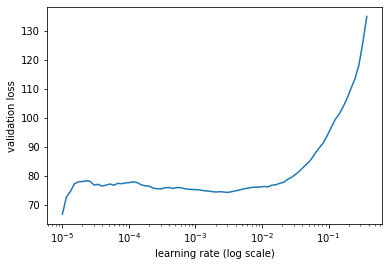

In [21]:
# Train the network with varying learning rates, with the final layers being trained at the fastest rate,
# and keeping much of the information from the earlier layers from ResNet34
lrs = np.array([lr/100, lr/10, lr])
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [22]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

  3%|▎         | 3/101 [00:02<02:13,  1.36s/it, loss=78.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:35,  1.02it/s, loss=76.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:02<00:56,  1.69it/s, loss=78.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:02<00:42,  2.21it/s, loss=77.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:42,  2.18it/s, loss=78.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:21,  4.12it/s, loss=76.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:04<00:17,  4.98it/s, loss=75.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:21,  3.91it/s, loss=74.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:05<00:24,  3.44it/s, loss=74.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:26,  3.08it/s, loss=74.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:06<00:23,  3.51it/s, loss=74.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:06<00:15,  4.92it/s, loss=74.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:24,  3.13it/s, loss=74.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:07<00:23,  3.17it/s, loss=74.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:08<00:20,  3.53it/s, loss=74.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:08<00:22,  3.28it/s, loss=74.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:09<00:19,  3.60it/s, loss=74.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:10<00:19,  3.43it/s, loss=74.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:10<00:16,  4.10it/s, loss=74.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:10<00:20,  3.24it/s, loss=75]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:11<00:13,  4.65it/s, loss=74.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:11<00:11,  5.50it/s, loss=75.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:12<00:16,  3.69it/s, loss=75.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:12<00:13,  4.41it/s, loss=75.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:12<00:10,  5.44it/s, loss=75.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:13<00:08,  6.14it/s, loss=75.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:13<00:18,  2.85it/s, loss=75.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:14<00:19,  2.66it/s, loss=75.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:14<00:15,  3.13it/s, loss=75.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:15<00:11,  4.34it/s, loss=75]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:15<00:08,  5.25it/s, loss=75.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:15<00:14,  3.07it/s, loss=75.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:16<00:12,  3.56it/s, loss=75.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:17<00:11,  3.46it/s, loss=75.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:17<00:08,  4.65it/s, loss=76]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:17<00:07,  5.36it/s, loss=75.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:13,  2.69it/s, loss=75.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:18<00:08,  3.99it/s, loss=75.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:19<00:10,  3.40it/s, loss=75.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:19<00:08,  3.64it/s, loss=75.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:19<00:06,  4.60it/s, loss=75.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:20<00:14,  2.07it/s, loss=75.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:21<00:06,  3.58it/s, loss=75.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 76%|███████▌  | 77/101 [00:21<00:05,  4.37it/s, loss=75.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:21<00:04,  5.12it/s, loss=76]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:21<00:04,  5.04it/s, loss=76.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:24<00:11,  1.72it/s, loss=76.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 82%|████████▏ | 83/101 [00:24<00:08,  2.25it/s, loss=76.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:24<00:04,  3.38it/s, loss=76.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:24<00:03,  4.01it/s, loss=76.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:25<00:02,  4.74it/s, loss=76.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:25<00:03,  3.73it/s, loss=76.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 89%|████████▉ | 90/101 [00:26<00:05,  2.13it/s, loss=76.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:26<00:02,  3.29it/s, loss=76.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 94%|█████████▍| 95/101 [00:27<00:01,  4.83it/s, loss=76.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:27<00:00,  4.27it/s, loss=76.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 99%|█████████▉| 100/101 [00:28<00:00,  5.34it/s, loss=76.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:31,  1.27s/it]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:25,  1.08s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  23%|██▎       | 6/26 [00:02<00:08,  2.24it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  31%|███       | 8/26 [00:02<00:05,  3.42it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  35%|███▍      | 9/26 [00:03<00:07,  2.35it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  42%|████▏     | 11/26 [00:03<00:04,  3.06it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  50%|█████     | 13/26 [00:04<00:03,  3.28it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  58%|█████▊    | 15/26 [00:04<00:02,  4.86it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.79it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:01,  4.44it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:01,  3.51it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:05<00:01,  3.78it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:02,  2.28it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  3.56it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

epoch      trn_loss   val_loss   detn_acc   detn_l1        
    0      76.937384  84.168123  0.35199    7.594763  
  2%|▏         | 2/101 [00:01<01:44,  1.06s/it, loss=76.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:02,  1.55it/s, loss=76.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:02<00:35,  2.67it/s, loss=75.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:02<00:27,  3.38it/s, loss=75.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:34,  2.64it/s, loss=75.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:29,  3.01it/s, loss=74.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:04<00:19,  4.42it/s, loss=75]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:04<00:16,  5.22it/s, loss=75.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:25,  3.36it/s, loss=74.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:21,  3.77it/s, loss=74.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:06<00:20,  4.00it/s, loss=74.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:07<00:18,  4.15it/s, loss=73.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:23,  3.23it/s, loss=73.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:08<00:19,  3.89it/s, loss=73.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:08<00:15,  4.65it/s, loss=73.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:08<00:21,  3.36it/s, loss=73.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:09<00:28,  2.50it/s, loss=73.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:10<00:24,  2.76it/s, loss=73.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:10<00:17,  3.77it/s, loss=72.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:11<00:19,  3.21it/s, loss=73]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:11<00:18,  3.26it/s, loss=72.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:12<00:19,  3.01it/s, loss=73.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:12<00:12,  4.46it/s, loss=72.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:13<00:14,  3.92it/s, loss=72.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:13<00:14,  3.78it/s, loss=72.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:14<00:16,  3.16it/s, loss=72.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:14<00:12,  3.96it/s, loss=72.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:15<00:12,  4.00it/s, loss=72.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:15<00:13,  3.62it/s, loss=72.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:17<00:14,  3.14it/s, loss=72.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:17<00:09,  4.42it/s, loss=72.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:17<00:07,  5.78it/s, loss=72.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:18<00:08,  4.54it/s, loss=72]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:07,  4.63it/s, loss=72]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:19<00:06,  5.12it/s, loss=72.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:19<00:06,  5.31it/s, loss=72.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:19<00:07,  4.64it/s, loss=72.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:20<00:07,  4.39it/s, loss=72]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:21<00:11,  2.60it/s, loss=72.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:21<00:06,  3.98it/s, loss=71.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 74%|███████▍  | 75/101 [00:21<00:06,  3.75it/s, loss=72]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:22<00:05,  4.04it/s, loss=71.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:24<00:08,  2.42it/s, loss=71.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:25<00:09,  1.92it/s, loss=71.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:25<00:03,  3.80it/s, loss=71.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:25<00:02,  4.68it/s, loss=71.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:26<00:05,  2.14it/s, loss=71.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 89%|████████▉ | 90/101 [00:27<00:05,  2.15it/s, loss=71.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 93%|█████████▎| 94/101 [00:27<00:01,  4.22it/s, loss=71.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:28<00:00,  5.17it/s, loss=71.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:28<00:01,  3.98it/s, loss=71.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]         

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:26,  1.12s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:19,  1.20it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  15%|█▌        | 4/26 [00:02<00:14,  1.57it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  27%|██▋       | 7/26 [00:02<00:07,  2.60it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  31%|███       | 8/26 [00:02<00:05,  3.15it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  38%|███▊      | 10/26 [00:03<00:06,  2.38it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  42%|████▏     | 11/26 [00:03<00:04,  3.02it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  50%|█████     | 13/26 [00:04<00:03,  3.82it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  58%|█████▊    | 15/26 [00:04<00:02,  4.59it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.91it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:05<00:01,  4.70it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.66it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.88it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  4.17it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    1      71.552115  80.954634  0.375622   7.7298         
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  1%|          | 1/101 [00:01<02:34,  1.54s/it, loss=71.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:01<01:20,  1.20it/s, loss=70.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:02<00:45,  2.11it/s, loss=70.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:02<00:36,  2.56it/s, loss=70]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:43,  2.10it/s, loss=69.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:31,  2.83it/s, loss=69.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:04<00:21,  4.05it/s, loss=68.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:04<00:15,  5.67it/s, loss=68.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:04<00:13,  6.12it/s, loss=68.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:06<00:32,  2.54it/s, loss=68.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:06<00:24,  3.26it/s, loss=67.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:06<00:16,  4.83it/s, loss=67.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:07<00:21,  3.61it/s, loss=67.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:08<00:18,  4.01it/s, loss=67.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:08<00:16,  4.41it/s, loss=67.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:08<00:14,  4.81it/s, loss=67.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:09<00:14,  4.82it/s, loss=67]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:09<00:18,  3.82it/s, loss=67]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:10<00:26,  2.56it/s, loss=67]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:11<00:27,  2.38it/s, loss=67.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:11<00:17,  3.68it/s, loss=66.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:11<00:12,  4.96it/s, loss=66.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:12<00:15,  3.77it/s, loss=66.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:12<00:13,  4.18it/s, loss=66.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:13<00:16,  3.39it/s, loss=66.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:13<00:23,  2.43it/s, loss=66.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:13<00:18,  2.93it/s, loss=66.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:14<00:14,  3.53it/s, loss=66.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:15<00:14,  3.46it/s, loss=65.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:15<00:11,  3.95it/s, loss=65.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:16<00:13,  3.48it/s, loss=65.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:16<00:14,  3.05it/s, loss=65.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:17<00:16,  2.66it/s, loss=65.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:17<00:14,  2.87it/s, loss=65.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:18<00:09,  4.16it/s, loss=65.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:18<00:11,  3.41it/s, loss=65.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:19<00:09,  3.86it/s, loss=65.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:19<00:10,  3.15it/s, loss=65.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:20<00:07,  4.28it/s, loss=64.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:21<00:07,  3.77it/s, loss=64.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 77%|███████▋  | 78/101 [00:22<00:03,  6.19it/s, loss=64.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:22<00:03,  6.39it/s, loss=64.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:24<00:10,  1.80it/s, loss=64.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 83%|████████▎ | 84/101 [00:25<00:06,  2.79it/s, loss=64.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:25<00:03,  4.09it/s, loss=64.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:25<00:02,  4.67it/s, loss=64.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:25<00:02,  4.51it/s, loss=64.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:26<00:04,  2.67it/s, loss=64.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:26<00:02,  3.84it/s, loss=64.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:26<00:01,  5.26it/s, loss=64.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 93%|█████████▎| 94/101 [00:27<00:01,  5.84it/s, loss=64.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:27<00:00,  6.13it/s, loss=64.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 97%|█████████▋| 98/101 [00:28<00:00,  3.69it/s, loss=64.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:24,  1.03s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:17,  1.29it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:09,  2.15it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:05,  3.31it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  31%|███       | 8/26 [00:02<00:04,  3.97it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  38%|███▊      | 10/26 [00:03<00:06,  2.34it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  46%|████▌     | 12/26 [00:04<00:04,  3.01it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  54%|█████▍    | 14/26 [00:04<00:03,  3.82it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.53it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  77%|███████▋  | 20/26 [00:05<00:01,  4.82it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.71it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    2      64.632406  77.911913  0.393657   7.693014  
  1%|          | 1/101 [00:01<02:50,  1.70s/it, loss=64.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  3%|▎         | 3/101 [00:02<01:34,  1.03it/s, loss=64.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:02<00:39,  2.41it/s, loss=63.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:02<00:25,  3.62it/s, loss=63.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:03<00:29,  3.08it/s, loss=63.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:03<00:23,  3.84it/s, loss=63]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:04<00:23,  3.74it/s, loss=62.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:04<00:19,  4.32it/s, loss=62.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:06<00:30,  2.69it/s, loss=62.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:24,  3.32it/s, loss=62.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:06<00:19,  4.10it/s, loss=61.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:07<00:24,  3.29it/s, loss=61.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:19,  4.03it/s, loss=61.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:08<00:31,  2.41it/s, loss=61.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:09<00:34,  2.18it/s, loss=61.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:09<00:25,  2.82it/s, loss=61]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:09<00:19,  3.57it/s, loss=60.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:10<00:16,  4.22it/s, loss=60.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:10<00:20,  3.19it/s, loss=60.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:11<00:16,  3.83it/s, loss=60.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:11<00:11,  5.31it/s, loss=60.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:12<00:12,  4.95it/s, loss=59.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:12<00:20,  2.83it/s, loss=59.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:13<00:18,  3.12it/s, loss=59.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:13<00:14,  3.93it/s, loss=59.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:13<00:12,  4.36it/s, loss=59.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:14<00:16,  3.16it/s, loss=59]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:14<00:14,  3.41it/s, loss=59.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:15<00:15,  3.17it/s, loss=59.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:15<00:12,  3.94it/s, loss=59.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:15<00:11,  3.96it/s, loss=59.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:16<00:09,  4.59it/s, loss=59.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:16<00:13,  3.24it/s, loss=59.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:17<00:12,  3.38it/s, loss=59]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:18<00:14,  2.83it/s, loss=59]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:18<00:08,  4.27it/s, loss=58.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:07,  5.02it/s, loss=58.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:19<00:09,  3.84it/s, loss=58.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:20<00:09,  3.43it/s, loss=59]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:20<00:09,  3.27it/s, loss=58.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:20<00:10,  2.95it/s, loss=58.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:21<00:07,  3.70it/s, loss=58.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:21<00:06,  4.10it/s, loss=58.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 74%|███████▍  | 75/101 [00:21<00:06,  4.05it/s, loss=58.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:21<00:06,  3.69it/s, loss=58.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 76%|███████▌  | 77/101 [00:22<00:07,  3.33it/s, loss=58.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:22<00:04,  4.76it/s, loss=58.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:24<00:16,  1.24it/s, loss=58.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:25<00:05,  2.81it/s, loss=58.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:25<00:03,  4.38it/s, loss=57.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:25<00:02,  4.86it/s, loss=58.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:26<00:04,  2.80it/s, loss=57.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:26<00:02,  4.27it/s, loss=58]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 94%|█████████▍| 95/101 [00:27<00:01,  3.90it/s, loss=57.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:27<00:01,  4.63it/s, loss=57.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:28<00:01,  3.03it/s, loss=57.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]         

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:25,  1.06s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:18,  1.24it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:10,  2.00it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:05,  3.24it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  31%|███       | 8/26 [00:02<00:04,  4.03it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  38%|███▊      | 10/26 [00:03<00:05,  3.08it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  42%|████▏     | 11/26 [00:03<00:03,  3.79it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  50%|█████     | 13/26 [00:04<00:03,  3.61it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  62%|██████▏   | 16/26 [00:04<00:01,  5.40it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.90it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:05<00:01,  4.93it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  3.11it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  3.03it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  4.42it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    3      58.134075  75.835738  0.410448   7.423973       
  2%|▏         | 2/101 [00:01<02:04,  1.26s/it, loss=58]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:06,  1.46it/s, loss=57.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:02<00:43,  2.17it/s, loss=57.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:02<00:26,  3.49it/s, loss=57.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:33,  2.74it/s, loss=57.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:03<00:31,  2.86it/s, loss=57.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:27,  3.25it/s, loss=57]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:04<00:21,  4.01it/s, loss=56.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:04<00:16,  5.23it/s, loss=56.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:29,  2.83it/s, loss=56.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:26,  3.06it/s, loss=56.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:06<00:21,  3.77it/s, loss=56.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:06<00:17,  4.60it/s, loss=56.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:15,  5.08it/s, loss=56.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:07<00:22,  3.34it/s, loss=56.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:08<00:21,  3.40it/s, loss=56.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:08<00:24,  2.96it/s, loss=56.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:09<00:19,  3.71it/s, loss=56.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:09<00:15,  4.31it/s, loss=55.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:09<00:14,  4.68it/s, loss=55.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:10<00:22,  2.92it/s, loss=55.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:10<00:24,  2.75it/s, loss=55.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:11<00:25,  2.52it/s, loss=55.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:11<00:15,  4.02it/s, loss=55.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:12<00:09,  6.49it/s, loss=54.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:12<00:12,  4.39it/s, loss=54.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:14<00:21,  2.52it/s, loss=55.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:14<00:13,  3.87it/s, loss=55.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:14<00:11,  4.62it/s, loss=55.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:15<00:13,  3.71it/s, loss=55]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:16<00:09,  5.16it/s, loss=55]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:16<00:07,  5.87it/s, loss=55]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:17<00:07,  5.47it/s, loss=54.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:17<00:07,  5.79it/s, loss=54.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:17<00:12,  3.24it/s, loss=54.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:18<00:12,  3.14it/s, loss=54.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:18<00:11,  3.50it/s, loss=54.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:18<00:10,  3.52it/s, loss=54.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:19<00:08,  4.20it/s, loss=54.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:19<00:07,  4.85it/s, loss=54.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:20<00:14,  2.32it/s, loss=54.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:20<00:08,  3.72it/s, loss=54.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:21<00:06,  3.90it/s, loss=54.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:21<00:06,  3.85it/s, loss=54.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:22<00:04,  4.84it/s, loss=54.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:24<00:08,  2.47it/s, loss=54.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:24<00:08,  2.22it/s, loss=54.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:25<00:04,  3.99it/s, loss=54.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:25<00:02,  5.12it/s, loss=54.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:25<00:03,  4.23it/s, loss=54.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 89%|████████▉ | 90/101 [00:26<00:03,  3.10it/s, loss=54.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:27<00:02,  3.64it/s, loss=54.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:27<00:01,  4.45it/s, loss=54.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 93%|█████████▎| 94/101 [00:27<00:01,  4.16it/s, loss=54.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:27<00:01,  4.66it/s, loss=54.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:28<00:00,  4.43it/s, loss=54.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 97%|█████████▋| 98/101 [00:28<00:00,  4.01it/s, loss=54]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:32,  1.29s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:25,  1.05s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  23%|██▎       | 6/26 [00:02<00:11,  1.79it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  31%|███       | 8/26 [00:02<00:06,  2.98it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  35%|███▍      | 9/26 [00:03<00:09,  1.76it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  42%|████▏     | 11/26 [00:03<00:06,  2.34it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  50%|█████     | 13/26 [00:04<00:03,  3.41it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  58%|█████▊    | 15/26 [00:04<00:02,  4.73it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.68it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:01,  6.22it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.70it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.86it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  4.07it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    4      53.853494  75.173842  0.418532   7.381644       


/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[75.17384161877987, 0.4185323383084577, 7.38164449805644]

In [27]:
learn.unfreeze()
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

  1%|          | 1/101 [00:02<03:21,  2.01s/it, loss=85.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  2%|▏         | 2/101 [00:02<02:29,  1.51s/it, loss=84.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:20,  1.21it/s, loss=86.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<01:01,  1.55it/s, loss=87.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:03<00:38,  2.42it/s, loss=88.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:03<00:32,  2.89it/s, loss=88.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:04<00:41,  2.24it/s, loss=90.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:04<00:34,  2.64it/s, loss=91.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:29,  3.09it/s, loss=91.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:27,  3.22it/s, loss=91.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:05<00:21,  4.04it/s, loss=89.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:19,  4.31it/s, loss=89.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:06<00:34,  2.47it/s, loss=88.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:07<00:48,  1.70it/s, loss=88.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:07<00:31,  2.57it/s, loss=88.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:08<00:22,  3.45it/s, loss=87.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:08<00:20,  3.85it/s, loss=87]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:08<00:18,  4.18it/s, loss=86.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:09<00:21,  3.50it/s, loss=86.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:09<00:17,  4.25it/s, loss=84.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:09<00:15,  4.69it/s, loss=83.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:10<00:15,  4.54it/s, loss=83.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:10<00:15,  4.47it/s, loss=82.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:10<00:17,  4.02it/s, loss=82.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:11<00:32,  2.10it/s, loss=81.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:11<00:25,  2.59it/s, loss=82]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:12<00:23,  2.85it/s, loss=81.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:12<00:17,  3.68it/s, loss=80.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:12<00:14,  4.32it/s, loss=79.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:13<00:17,  3.53it/s, loss=79.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:13<00:20,  2.88it/s, loss=79.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:14<00:16,  3.57it/s, loss=78.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:14<00:23,  2.42it/s, loss=78.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:15<00:16,  3.26it/s, loss=78]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:15<00:13,  3.81it/s, loss=77.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:16<00:15,  3.45it/s, loss=76.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:16<00:15,  3.25it/s, loss=76.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:17<00:17,  2.83it/s, loss=75.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:17<00:12,  3.67it/s, loss=75.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:18<00:12,  3.70it/s, loss=75]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:18<00:14,  2.96it/s, loss=74.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:18<00:10,  3.91it/s, loss=74]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:19<00:11,  3.48it/s, loss=73.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:20<00:16,  2.31it/s, loss=73]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:20<00:12,  3.06it/s, loss=72.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:20<00:10,  3.40it/s, loss=72.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:21<00:08,  4.23it/s, loss=71.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:21<00:07,  4.24it/s, loss=71.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:21<00:09,  3.47it/s, loss=70.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:22<00:13,  2.25it/s, loss=70.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:23<00:08,  3.28it/s, loss=69.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:23<00:07,  3.55it/s, loss=69.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:23<00:05,  4.23it/s, loss=69.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 76%|███████▌  | 77/101 [00:24<00:05,  4.12it/s, loss=69]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:24<00:04,  4.98it/s, loss=68.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:26<00:15,  1.30it/s, loss=68.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:27<00:11,  1.67it/s, loss=68.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 83%|████████▎ | 84/101 [00:27<00:06,  2.60it/s, loss=67.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:27<00:04,  3.47it/s, loss=66.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:28<00:03,  4.15it/s, loss=66.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:28<00:03,  3.45it/s, loss=66.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:29<00:02,  3.40it/s, loss=66.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:29<00:02,  3.82it/s, loss=66.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 93%|█████████▎| 94/101 [00:29<00:01,  4.08it/s, loss=66]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:30<00:01,  4.62it/s, loss=65.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:30<00:01,  2.74it/s, loss=65.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 98%|█████████▊| 99/101 [00:31<00:00,  4.00it/s, loss=65.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:24,  1.02s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:17,  1.33it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:10,  1.96it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:07,  2.59it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  35%|███▍      | 9/26 [00:03<00:07,  2.39it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  42%|████▏     | 11/26 [00:03<00:04,  3.12it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  54%|█████▍    | 14/26 [00:04<00:03,  3.77it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  62%|██████▏   | 16/26 [00:04<00:02,  4.61it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  69%|██████▉   | 18/26 [00:04<00:01,  4.54it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.75it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.77it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      65.487146  71.145301  0.442164   8.106984  
  1%|          | 1/101 [00:01<03:09,  1.89s/it, loss=65.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  2%|▏         | 2/101 [00:02<02:22,  1.44s/it, loss=64.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:18,  1.23it/s, loss=64.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<00:59,  1.61it/s, loss=63.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:03<00:37,  2.49it/s, loss=63.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:04<00:48,  1.88it/s, loss=62.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:32,  2.81it/s, loss=62.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:27,  3.20it/s, loss=62.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:05<00:25,  3.50it/s, loss=61.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:05<00:20,  4.17it/s, loss=60.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:20,  4.21it/s, loss=60.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:06<00:25,  3.23it/s, loss=60.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:20,  4.06it/s, loss=59.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:07<00:28,  2.83it/s, loss=59.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:07<00:21,  3.66it/s, loss=59.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:07<00:19,  3.94it/s, loss=59.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:09<00:39,  1.91it/s, loss=58.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:09<00:25,  2.88it/s, loss=58]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:10<00:19,  3.72it/s, loss=57.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:10<00:15,  4.44it/s, loss=57.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:10<00:15,  4.48it/s, loss=56.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:11<00:22,  2.99it/s, loss=56.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:11<00:30,  2.22it/s, loss=56.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:12<00:20,  3.15it/s, loss=56.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:12<00:18,  3.44it/s, loss=56.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:12<00:16,  3.84it/s, loss=56.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:13<00:14,  4.27it/s, loss=56]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:13<00:21,  2.81it/s, loss=56]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:14<00:15,  3.75it/s, loss=55.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:14<00:14,  4.03it/s, loss=55.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:14<00:14,  3.90it/s, loss=55.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:15<00:12,  4.48it/s, loss=55.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:15<00:11,  4.64it/s, loss=55.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:16<00:24,  2.08it/s, loss=55]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:16<00:20,  2.48it/s, loss=54.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:16<00:17,  2.79it/s, loss=54.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:16<00:15,  3.19it/s, loss=54.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:17<00:13,  3.55it/s, loss=54.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:17<00:10,  4.46it/s, loss=54.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:17<00:10,  4.45it/s, loss=54.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:18<00:13,  3.38it/s, loss=54.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:19<00:21,  2.00it/s, loss=54.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:19<00:17,  2.44it/s, loss=54]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:19<00:14,  2.83it/s, loss=53.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:19<00:10,  3.77it/s, loss=53.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:20<00:08,  4.33it/s, loss=52.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:21<00:13,  2.65it/s, loss=52.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:21<00:09,  3.48it/s, loss=52.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:21<00:08,  3.87it/s, loss=52.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:22<00:08,  3.51it/s, loss=51.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:22<00:07,  4.08it/s, loss=51.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:23<00:09,  2.87it/s, loss=51.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:23<00:08,  3.02it/s, loss=51.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:23<00:06,  3.98it/s, loss=51.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 77%|███████▋  | 78/101 [00:24<00:04,  4.99it/s, loss=51.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:24<00:03,  5.93it/s, loss=51.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:26<00:12,  1.58it/s, loss=51.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:26<00:09,  1.92it/s, loss=51]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 83%|████████▎ | 84/101 [00:26<00:05,  2.87it/s, loss=50.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:27<00:03,  3.82it/s, loss=50.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:27<00:03,  4.17it/s, loss=51]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:28<00:04,  2.49it/s, loss=50.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:29<00:04,  2.33it/s, loss=50.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:29<00:03,  2.80it/s, loss=50.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:29<00:02,  3.14it/s, loss=50.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 93%|█████████▎| 94/101 [00:29<00:01,  3.55it/s, loss=50.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:30<00:01,  4.37it/s, loss=50.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 97%|█████████▋| 98/101 [00:31<00:01,  2.93it/s, loss=50.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 99%|█████████▉| 100/101 [00:31<00:00,  4.21it/s, loss=50] 

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:32,  1.29s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:21,  1.05it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:12,  1.71it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:06,  2.82it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  31%|███       | 8/26 [00:02<00:05,  3.51it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  35%|███▍      | 9/26 [00:03<00:08,  1.93it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  42%|████▏     | 11/26 [00:03<00:05,  2.55it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  50%|█████     | 13/26 [00:04<00:03,  3.45it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  54%|█████▍    | 14/26 [00:04<00:02,  4.27it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.75it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  73%|███████▎  | 19/26 [00:05<00:01,  3.91it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:05<00:01,  4.20it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  3.15it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  4.63it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    1      49.749544  60.250644  0.524876   7.921036       
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  1%|          | 1/101 [00:02<03:26,  2.06s/it, loss=49.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  2%|▏         | 2/101 [00:02<02:29,  1.51s/it, loss=49]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:21,  1.19it/s, loss=48.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:03<00:48,  1.94it/s, loss=47.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:03<00:32,  2.88it/s, loss=47.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:04<00:42,  2.16it/s, loss=47.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:34,  2.64it/s, loss=46.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:05<00:24,  3.57it/s, loss=46.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:05<00:20,  4.10it/s, loss=45.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:19,  4.35it/s, loss=45.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:06<00:28,  2.96it/s, loss=45.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:06<00:33,  2.44it/s, loss=45.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:07<00:24,  3.34it/s, loss=44.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:07<00:19,  4.08it/s, loss=44.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:07<00:18,  4.33it/s, loss=44.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:08<00:26,  2.92it/s, loss=44]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:09<00:27,  2.70it/s, loss=43.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:09<00:23,  3.15it/s, loss=43.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:09<00:21,  3.42it/s, loss=43.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:10<00:16,  4.18it/s, loss=42.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:10<00:15,  4.37it/s, loss=42.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:11<00:26,  2.61it/s, loss=42.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:11<00:19,  3.42it/s, loss=42.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:11<00:15,  4.10it/s, loss=41.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:12<00:14,  4.40it/s, loss=41.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:12<00:14,  4.30it/s, loss=41.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:13<00:19,  3.07it/s, loss=41.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:13<00:22,  2.65it/s, loss=41.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:13<00:18,  3.10it/s, loss=41.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:14<00:16,  3.47it/s, loss=40.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:14<00:16,  3.28it/s, loss=40.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:15<00:14,  3.62it/s, loss=40.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:15<00:16,  3.09it/s, loss=40.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:16<00:21,  2.38it/s, loss=40.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:17<00:29,  1.64it/s, loss=40.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:17<00:23,  2.06it/s, loss=40.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:18<00:15,  3.02it/s, loss=40]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:18<00:11,  3.89it/s, loss=39.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:18<00:10,  4.20it/s, loss=39.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:18<00:09,  4.45it/s, loss=39.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:19<00:08,  4.78it/s, loss=39.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:19<00:09,  3.93it/s, loss=39.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:20<00:11,  3.24it/s, loss=39.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:20<00:11,  3.12it/s, loss=39.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:21<00:13,  2.69it/s, loss=39]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:21<00:10,  3.10it/s, loss=39]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:21<00:08,  3.81it/s, loss=38.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:22<00:10,  2.84it/s, loss=38.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:23<00:10,  2.64it/s, loss=38.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:23<00:09,  2.94it/s, loss=38.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 74%|███████▍  | 75/101 [00:23<00:06,  4.10it/s, loss=38.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:23<00:05,  4.26it/s, loss=38.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 77%|███████▋  | 78/101 [00:24<00:04,  5.14it/s, loss=37.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:24<00:04,  4.51it/s, loss=37.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:26<00:16,  1.22it/s, loss=37.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:27<00:12,  1.56it/s, loss=38]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 82%|████████▏ | 83/101 [00:27<00:09,  1.97it/s, loss=38]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:27<00:05,  2.91it/s, loss=38.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:27<00:03,  3.84it/s, loss=38]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:28<00:03,  3.24it/s, loss=37.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:29<00:03,  2.62it/s, loss=37.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:29<00:02,  3.59it/s, loss=37.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 94%|█████████▍| 95/101 [00:30<00:01,  4.38it/s, loss=37.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:30<00:01,  3.06it/s, loss=37.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 98%|█████████▊| 99/101 [00:31<00:00,  4.32it/s, loss=37.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:34,  1.37s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:18,  1.28it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:09,  2.22it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:05,  3.63it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  31%|███       | 8/26 [00:02<00:04,  4.25it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  42%|████▏     | 11/26 [00:03<00:04,  3.06it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  50%|█████     | 13/26 [00:03<00:03,  4.03it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  54%|█████▍    | 14/26 [00:04<00:02,  4.30it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.48it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:02,  3.70it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:05<00:01,  3.46it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:02,  2.39it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  3.75it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    2      36.924311  54.666712  0.567164   7.684567       
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  1%|          | 1/101 [00:01<02:53,  1.74s/it, loss=36.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  3%|▎         | 3/101 [00:02<01:32,  1.05it/s, loss=36.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:10,  1.38it/s, loss=36.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:02<00:43,  2.18it/s, loss=35.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:03<00:30,  3.02it/s, loss=35.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:04<00:46,  1.99it/s, loss=35.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:04<00:38,  2.39it/s, loss=35.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:28,  3.14it/s, loss=35]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:05<00:25,  3.37it/s, loss=34.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:20,  4.10it/s, loss=34.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:06<00:33,  2.54it/s, loss=34.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:06<00:35,  2.32it/s, loss=34.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:07<00:25,  3.22it/s, loss=34.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:07<00:19,  4.08it/s, loss=33.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:16,  4.57it/s, loss=33.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:08<00:27,  2.77it/s, loss=33.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:09<00:30,  2.47it/s, loss=33.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:09<00:25,  2.92it/s, loss=33.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:09<00:20,  3.48it/s, loss=33.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:10<00:17,  4.05it/s, loss=33]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:10<00:15,  4.35it/s, loss=33]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:10<00:19,  3.50it/s, loss=32.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:11<00:20,  3.31it/s, loss=32.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:11<00:20,  3.21it/s, loss=32.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:11<00:16,  3.79it/s, loss=32.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:12<00:21,  2.86it/s, loss=32.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:13<00:23,  2.53it/s, loss=32.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:13<00:23,  2.49it/s, loss=32.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:14<00:21,  2.73it/s, loss=32.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:15<00:28,  2.00it/s, loss=32.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:15<00:18,  3.01it/s, loss=32.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:15<00:13,  3.83it/s, loss=31.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:17<00:27,  1.87it/s, loss=31.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:17<00:17,  2.88it/s, loss=31.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:17<00:12,  3.72it/s, loss=31.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:18<00:11,  4.02it/s, loss=31.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:18<00:09,  4.49it/s, loss=31.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:18<00:10,  4.06it/s, loss=31.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:19<00:09,  4.28it/s, loss=31.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:19<00:13,  3.14it/s, loss=31]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:19<00:11,  3.60it/s, loss=31]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:20<00:09,  3.98it/s, loss=30.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:20<00:08,  4.18it/s, loss=30.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:21<00:11,  3.06it/s, loss=30.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:21<00:13,  2.51it/s, loss=30.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:22<00:13,  2.31it/s, loss=30.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:22<00:09,  3.16it/s, loss=30.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:23<00:08,  3.54it/s, loss=30.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:23<00:08,  3.18it/s, loss=30.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 74%|███████▍  | 75/101 [00:23<00:07,  3.63it/s, loss=30.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:24<00:06,  3.76it/s, loss=30.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 77%|███████▋  | 78/101 [00:24<00:04,  4.85it/s, loss=30.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:24<00:03,  5.82it/s, loss=30.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:26<00:13,  1.44it/s, loss=30]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 82%|████████▏ | 83/101 [00:27<00:10,  1.67it/s, loss=30]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:27<00:06,  2.59it/s, loss=29.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:28<00:04,  3.45it/s, loss=30.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:28<00:02,  4.20it/s, loss=29.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 89%|████████▉ | 90/101 [00:29<00:03,  3.40it/s, loss=29.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:29<00:03,  2.95it/s, loss=29.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:29<00:02,  3.86it/s, loss=29.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 94%|█████████▍| 95/101 [00:30<00:01,  4.59it/s, loss=29.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:30<00:00,  5.45it/s, loss=29.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 97%|█████████▋| 98/101 [00:31<00:00,  3.69it/s, loss=29.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:32,  1.31s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:24,  1.00s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  15%|█▌        | 4/26 [00:02<00:17,  1.26it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  23%|██▎       | 6/26 [00:02<00:09,  2.21it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  31%|███       | 8/26 [00:02<00:06,  2.88it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  38%|███▊      | 10/26 [00:03<00:06,  2.35it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  46%|████▌     | 12/26 [00:03<00:04,  3.08it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  54%|█████▍    | 14/26 [00:04<00:03,  3.95it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  62%|██████▏   | 16/26 [00:04<00:02,  4.87it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  4.78it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:01,  4.14it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:05<00:01,  3.27it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.57it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


    3      29.257867  51.996547  0.599502   7.551209       
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

  1%|          | 1/101 [00:01<03:01,  1.82s/it, loss=29.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  3%|▎         | 3/101 [00:02<01:39,  1.02s/it, loss=29]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:17,  1.25it/s, loss=28.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<00:59,  1.60it/s, loss=28.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:03<00:47,  2.00it/s, loss=28.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:03<00:31,  2.94it/s, loss=28.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:36,  2.53it/s, loss=28.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:04<00:33,  2.71it/s, loss=28.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:31,  2.81it/s, loss=28.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:04<00:24,  3.63it/s, loss=28]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:05<00:19,  4.52it/s, loss=27.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:21,  3.92it/s, loss=27.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:06<00:29,  2.81it/s, loss=27.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:06<00:35,  2.32it/s, loss=27.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:07<00:24,  3.35it/s, loss=27.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:07<00:19,  4.00it/s, loss=27.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:07<00:16,  4.56it/s, loss=26.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:09<00:52,  1.44it/s, loss=26.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:09<00:40,  1.84it/s, loss=26.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:10<00:32,  2.24it/s, loss=26.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:10<00:22,  3.17it/s, loss=26.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:10<00:19,  3.56it/s, loss=26.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:11<00:15,  4.40it/s, loss=26.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:11<00:14,  4.54it/s, loss=26.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:11<00:13,  4.96it/s, loss=25.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:11<00:13,  5.00it/s, loss=25.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:12<00:12,  5.11it/s, loss=25.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:12<00:11,  5.17it/s, loss=25.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:13<00:21,  2.76it/s, loss=25.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:13<00:18,  3.12it/s, loss=25.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:14<00:17,  3.32it/s, loss=25.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:14<00:14,  3.78it/s, loss=25.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:14<00:16,  3.33it/s, loss=25.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:14<00:14,  3.76it/s, loss=25.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:16<00:29,  1.77it/s, loss=25.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:16<00:22,  2.23it/s, loss=24.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:16<00:15,  3.10it/s, loss=24.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:17<00:14,  3.41it/s, loss=24.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:17<00:11,  4.09it/s, loss=24.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:18<00:12,  3.45it/s, loss=24.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:18<00:15,  2.86it/s, loss=24.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:19<00:10,  3.79it/s, loss=24.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:19<00:09,  4.21it/s, loss=24.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:19<00:10,  3.57it/s, loss=24.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:20<00:13,  2.70it/s, loss=24.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:20<00:11,  3.11it/s, loss=24.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:21<00:15,  2.22it/s, loss=24.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:21<00:12,  2.65it/s, loss=24.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:22<00:09,  3.15it/s, loss=24.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:22<00:08,  3.64it/s, loss=24.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:23<00:08,  3.18it/s, loss=24.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 74%|███████▍  | 75/101 [00:23<00:06,  3.90it/s, loss=24.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:23<00:06,  3.83it/s, loss=24.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 77%|███████▋  | 78/101 [00:24<00:04,  4.80it/s, loss=24.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:24<00:04,  4.62it/s, loss=24.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:26<00:14,  1.35it/s, loss=24.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:26<00:11,  1.68it/s, loss=24.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 83%|████████▎ | 84/101 [00:27<00:06,  2.57it/s, loss=24.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:27<00:04,  3.50it/s, loss=24.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:27<00:03,  4.16it/s, loss=24.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:28<00:04,  2.68it/s, loss=24.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:29<00:02,  3.54it/s, loss=24.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:29<00:02,  3.66it/s, loss=24.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 93%|█████████▎| 94/101 [00:29<00:01,  4.41it/s, loss=24.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:30<00:00,  5.05it/s, loss=24.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:30<00:01,  2.64it/s, loss=24.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 98%|█████████▊| 99/101 [00:31<00:00,  3.90it/s, loss=24.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:36,  1.47s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  12%|█▏        | 3/26 [00:01<00:24,  1.05s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  15%|█▌        | 4/26 [00:01<00:18,  1.22it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  23%|██▎       | 6/26 [00:02<00:12,  1.65it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  31%|███       | 8/26 [00:02<00:08,  2.18it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  35%|███▍      | 9/26 [00:03<00:11,  1.48it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  46%|████▌     | 12/26 [00:03<00:05,  2.44it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  54%|█████▍    | 14/26 [00:04<00:03,  3.78it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  62%|██████▏   | 16/26 [00:04<00:02,  4.59it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.44it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:01,  5.06it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.51it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:05<00:02,  2.78it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.60it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  3.93it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    4      24.668621  49.642522  0.609453   7.402255       
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  1%|          | 1/101 [00:02<03:29,  2.09s/it, loss=24.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  3%|▎         | 3/101 [00:02<01:48,  1.11s/it, loss=24.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<01:01,  1.55it/s, loss=24.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:03<00:38,  2.42it/s, loss=24]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:35,  2.59it/s, loss=23.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:27,  3.31it/s, loss=23.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:30,  2.96it/s, loss=23.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:05<00:22,  3.89it/s, loss=23.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:18,  4.52it/s, loss=23.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:06<00:38,  2.21it/s, loss=23.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:06<00:36,  2.30it/s, loss=23.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:07<00:25,  3.22it/s, loss=23.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:07<00:23,  3.42it/s, loss=23.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:07<00:21,  3.70it/s, loss=23.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:08<00:17,  4.46it/s, loss=23]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:08<00:26,  2.82it/s, loss=22.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:09<00:25,  2.89it/s, loss=22.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:09<00:18,  3.95it/s, loss=22.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:09<00:24,  2.89it/s, loss=22.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:10<00:21,  3.24it/s, loss=22.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:10<00:17,  3.98it/s, loss=22.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:11<00:27,  2.44it/s, loss=22.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:11<00:25,  2.66it/s, loss=22.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:12<00:18,  3.45it/s, loss=22.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:12<00:23,  2.65it/s, loss=22.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:13<00:20,  3.03it/s, loss=22.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:13<00:15,  3.83it/s, loss=22.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:13<00:14,  3.98it/s, loss=22.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:14<00:12,  4.55it/s, loss=22.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:14<00:14,  3.81it/s, loss=22.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:14<00:17,  3.15it/s, loss=22.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:15<00:26,  2.06it/s, loss=22.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:15<00:21,  2.50it/s, loss=22.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:16<00:17,  2.95it/s, loss=22.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:16<00:12,  3.89it/s, loss=22.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:16<00:12,  3.89it/s, loss=22.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:16<00:11,  4.17it/s, loss=22.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:17<00:16,  2.87it/s, loss=22]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 54%|█████▍    | 55/101 [00:17<00:14,  3.28it/s, loss=21.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:18<00:12,  3.52it/s, loss=21.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:18<00:14,  2.98it/s, loss=21.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:18<00:12,  3.41it/s, loss=21.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:19<00:09,  4.16it/s, loss=21.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:19<00:09,  4.13it/s, loss=21.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:19<00:11,  3.41it/s, loss=21.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:20<00:15,  2.53it/s, loss=21.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:20<00:10,  3.48it/s, loss=21.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:21<00:09,  3.42it/s, loss=21.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:22<00:14,  2.26it/s, loss=21.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:22<00:11,  2.65it/s, loss=21.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:23<00:13,  2.25it/s, loss=21.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:23<00:11,  2.50it/s, loss=21.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:23<00:07,  3.59it/s, loss=21.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:24<00:05,  4.51it/s, loss=21.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 77%|███████▋  | 78/101 [00:24<00:04,  5.26it/s, loss=21.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:24<00:03,  5.66it/s, loss=21.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:26<00:13,  1.46it/s, loss=21.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:26<00:10,  1.83it/s, loss=21.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 83%|████████▎ | 84/101 [00:27<00:06,  2.67it/s, loss=21]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:27<00:05,  3.08it/s, loss=21]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:27<00:04,  3.36it/s, loss=21]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:28<00:03,  4.24it/s, loss=21]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:28<00:03,  3.67it/s, loss=21]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 89%|████████▉ | 90/101 [00:29<00:04,  2.43it/s, loss=21]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:29<00:03,  2.82it/s, loss=21]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:29<00:02,  3.07it/s, loss=20.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 93%|█████████▎| 94/101 [00:29<00:01,  3.98it/s, loss=20.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:30<00:01,  4.82it/s, loss=20.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 97%|█████████▋| 98/101 [00:30<00:00,  4.46it/s, loss=20.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 98%|█████████▊| 99/101 [00:31<00:00,  3.58it/s, loss=20.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:32,  1.29s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:23,  1.02it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:17,  1.32it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:09,  2.12it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:05,  3.50it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  38%|███▊      | 10/26 [00:03<00:04,  3.20it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  46%|████▌     | 12/26 [00:04<00:03,  4.54it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  50%|█████     | 13/26 [00:04<00:02,  5.31it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  62%|██████▏   | 16/26 [00:04<00:01,  6.92it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  7.55it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:01,  4.98it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.75it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.88it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  4.15it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    5      20.897492  48.918151  0.607587   7.344578       
  1%|          | 1/101 [00:01<03:00,  1.81s/it, loss=20.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  2%|▏         | 2/101 [00:02<02:11,  1.33s/it, loss=20.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:12,  1.34it/s, loss=20.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<00:55,  1.72it/s, loss=20.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:02<00:44,  2.15it/s, loss=20.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  7%|▋         | 7/101 [00:03<00:39,  2.38it/s, loss=20.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:41,  2.24it/s, loss=20.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:04<00:34,  2.63it/s, loss=20.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:32,  2.74it/s, loss=20]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:33,  2.66it/s, loss=20]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:05<00:24,  3.48it/s, loss=19.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:05<00:22,  3.77it/s, loss=19.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:21,  4.03it/s, loss=19.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:05<00:20,  4.07it/s, loss=19.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 18%|█▊        | 18/101 [00:06<00:29,  2.77it/s, loss=19.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:29,  2.80it/s, loss=19.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:07<00:25,  3.12it/s, loss=19.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:07<00:23,  3.39it/s, loss=19.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:07<00:18,  4.19it/s, loss=19.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:08<00:17,  4.36it/s, loss=19.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:08<00:27,  2.73it/s, loss=19.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:08<00:25,  2.97it/s, loss=19.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:09<00:24,  3.07it/s, loss=19.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:09<00:19,  3.67it/s, loss=19.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:09<00:17,  4.07it/s, loss=19.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 31%|███       | 31/101 [00:10<00:16,  4.35it/s, loss=19.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:11<00:32,  2.12it/s, loss=19.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:11<00:29,  2.25it/s, loss=19.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:11<00:24,  2.64it/s, loss=19.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:12<00:21,  3.03it/s, loss=19.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:12<00:20,  3.03it/s, loss=19.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:13<00:21,  2.88it/s, loss=19.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:13<00:21,  2.85it/s, loss=19.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:14<00:25,  2.34it/s, loss=19.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:14<00:17,  3.21it/s, loss=19.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:15<00:15,  3.61it/s, loss=19.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:15<00:13,  4.06it/s, loss=19]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:16<00:19,  2.70it/s, loss=19]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:16<00:16,  3.16it/s, loss=18.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:16<00:14,  3.46it/s, loss=18.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:16<00:11,  4.30it/s, loss=18.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:17<00:12,  3.74it/s, loss=18.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:17<00:11,  3.99it/s, loss=18.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:18<00:15,  2.94it/s, loss=18.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:18<00:14,  3.10it/s, loss=18.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:18<00:14,  3.04it/s, loss=18.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:19<00:12,  3.33it/s, loss=18.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:19<00:11,  3.72it/s, loss=18.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:19<00:13,  2.89it/s, loss=18.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:20<00:12,  3.04it/s, loss=18.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 63%|██████▎   | 64/101 [00:21<00:17,  2.10it/s, loss=18.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:21<00:14,  2.53it/s, loss=18.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:21<00:09,  3.54it/s, loss=18.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:21<00:08,  3.89it/s, loss=18.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:22<00:08,  3.83it/s, loss=18.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:23<00:14,  1.94it/s, loss=18.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:24<00:09,  2.90it/s, loss=18.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:24<00:06,  4.14it/s, loss=18.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 77%|███████▋  | 78/101 [00:24<00:04,  5.28it/s, loss=18.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:24<00:03,  6.12it/s, loss=18.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:27<00:14,  1.33it/s, loss=18.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 82%|████████▏ | 83/101 [00:27<00:08,  2.03it/s, loss=18.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:27<00:05,  3.02it/s, loss=18.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:28<00:03,  3.87it/s, loss=18.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:29<00:04,  2.43it/s, loss=18.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 89%|████████▉ | 90/101 [00:29<00:03,  2.83it/s, loss=18.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:29<00:02,  3.71it/s, loss=18.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 93%|█████████▎| 94/101 [00:30<00:01,  4.51it/s, loss=18.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:30<00:00,  5.31it/s, loss=18.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:31<00:01,  3.33it/s, loss=18]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 98%|█████████▊| 99/101 [00:31<00:00,  4.59it/s, loss=18]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:33,  1.33s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:24,  1.00s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  15%|█▌        | 4/26 [00:01<00:16,  1.37it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  27%|██▋       | 7/26 [00:02<00:07,  2.43it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  35%|███▍      | 9/26 [00:03<00:08,  2.00it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  46%|████▌     | 12/26 [00:03<00:04,  3.41it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  54%|█████▍    | 14/26 [00:03<00:02,  4.28it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  62%|██████▏   | 16/26 [00:04<00:01,  5.45it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:01,  4.67it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.33it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.75it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


    6      18.198981  47.603951  0.623756   7.264211       
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

  1%|          | 1/101 [00:01<02:57,  1.78s/it, loss=18.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  2%|▏         | 2/101 [00:02<02:21,  1.43s/it, loss=18.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:16,  1.27it/s, loss=18.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  5%|▍         | 5/101 [00:02<00:59,  1.63it/s, loss=18.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:03<00:46,  2.03it/s, loss=18.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:03<00:32,  2.90it/s, loss=18]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:04<00:35,  2.62it/s, loss=17.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 11%|█         | 11/101 [00:04<00:26,  3.39it/s, loss=17.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:05<00:47,  1.88it/s, loss=17.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:05<00:31,  2.73it/s, loss=17.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:06<00:23,  3.68it/s, loss=17.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:06<00:20,  4.08it/s, loss=17.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:20,  3.92it/s, loss=17.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:07<00:17,  4.45it/s, loss=17.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 22%|██▏       | 22/101 [00:07<00:20,  3.94it/s, loss=17.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:08<00:26,  2.86it/s, loss=17.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:08<00:25,  2.93it/s, loss=17.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 26%|██▌       | 26/101 [00:09<00:28,  2.64it/s, loss=17.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:09<00:20,  3.51it/s, loss=17.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:10<00:19,  3.59it/s, loss=17.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:10<00:16,  4.24it/s, loss=17.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:11<00:33,  2.00it/s, loss=17.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:11<00:28,  2.39it/s, loss=17.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:12<00:24,  2.73it/s, loss=17.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:12<00:24,  2.69it/s, loss=17.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:12<00:17,  3.59it/s, loss=17.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:13<00:14,  4.20it/s, loss=17.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:13<00:18,  3.26it/s, loss=17.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:14<00:16,  3.52it/s, loss=17.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:14<00:13,  4.07it/s, loss=17.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:14<00:15,  3.58it/s, loss=17]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:14<00:13,  3.96it/s, loss=17.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:15<00:13,  3.84it/s, loss=17]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:16<00:18,  2.84it/s, loss=17]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:16<00:23,  2.17it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:17<00:20,  2.45it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:17<00:14,  3.31it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:17<00:12,  3.72it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:18<00:10,  4.19it/s, loss=16.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:18<00:12,  3.47it/s, loss=16.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:18<00:15,  2.77it/s, loss=16.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:19<00:16,  2.54it/s, loss=16.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:19<00:11,  3.48it/s, loss=16.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:20<00:12,  3.05it/s, loss=16.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:20<00:11,  3.44it/s, loss=16.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:20<00:08,  4.32it/s, loss=16.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:21<00:09,  3.51it/s, loss=16.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:21<00:12,  2.67it/s, loss=16.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:22<00:12,  2.74it/s, loss=16.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:22<00:10,  3.13it/s, loss=16.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:22<00:09,  3.40it/s, loss=16.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:22<00:07,  4.08it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:23<00:07,  3.45it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 74%|███████▍  | 75/101 [00:24<00:08,  2.99it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:24<00:08,  2.90it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 76%|███████▌  | 77/101 [00:24<00:07,  3.06it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:24<00:05,  4.33it/s, loss=17]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:26<00:13,  1.48it/s, loss=17]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:27<00:11,  1.61it/s, loss=17]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 82%|████████▏ | 83/101 [00:27<00:09,  1.99it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:27<00:05,  2.98it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:28<00:03,  3.85it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:29<00:04,  2.60it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 89%|████████▉ | 90/101 [00:29<00:03,  3.00it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:29<00:02,  3.34it/s, loss=16.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 91%|█████████ | 92/101 [00:29<00:02,  3.77it/s, loss=16.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 93%|█████████▎| 94/101 [00:30<00:01,  4.38it/s, loss=16.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:30<00:01,  4.91it/s, loss=16.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:31<00:01,  3.38it/s, loss=16.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 98%|█████████▊| 99/101 [00:31<00:00,  4.59it/s, loss=16.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:29,  1.19s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   8%|▊         | 2/26 [00:01<00:22,  1.05it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  15%|█▌        | 4/26 [00:02<00:16,  1.33it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  23%|██▎       | 6/26 [00:02<00:08,  2.30it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  31%|███       | 8/26 [00:02<00:05,  3.01it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  35%|███▍      | 9/26 [00:03<00:08,  1.94it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  42%|████▏     | 11/26 [00:03<00:05,  2.56it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  50%|█████     | 13/26 [00:04<00:03,  3.37it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  58%|█████▊    | 15/26 [00:04<00:02,  4.87it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  62%|██████▏   | 16/26 [00:04<00:01,  5.59it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:01,  5.12it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.73it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  2.87it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  3.92it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    7      16.727018  46.097974  0.629353   7.114011       
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  1%|          | 1/101 [00:01<03:01,  1.82s/it, loss=16.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  3%|▎         | 3/101 [00:02<01:36,  1.01it/s, loss=16.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:16,  1.26it/s, loss=16.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:02<00:46,  2.06it/s, loss=16.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:03<00:32,  2.87it/s, loss=16.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:04<00:50,  1.82it/s, loss=16.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:04<00:40,  2.25it/s, loss=16.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:27,  3.27it/s, loss=16.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 13%|█▎        | 13/101 [00:05<00:24,  3.65it/s, loss=16.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:05<00:29,  2.98it/s, loss=16.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:21,  3.90it/s, loss=16.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:06<00:37,  2.27it/s, loss=16.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:07<00:25,  3.21it/s, loss=16.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:07<00:20,  3.81it/s, loss=16.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:08<00:26,  2.98it/s, loss=16.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:09<00:31,  2.39it/s, loss=16]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:09<00:22,  3.33it/s, loss=16.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 28%|██▊       | 28/101 [00:10<00:40,  1.80it/s, loss=16]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:11<00:26,  2.67it/s, loss=16]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:11<00:19,  3.53it/s, loss=16.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 34%|███▎      | 34/101 [00:11<00:15,  4.24it/s, loss=16]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:12<00:14,  4.44it/s, loss=16]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 37%|███▋      | 37/101 [00:12<00:19,  3.33it/s, loss=16]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:13<00:19,  3.18it/s, loss=16]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 39%|███▊      | 39/101 [00:13<00:17,  3.45it/s, loss=16]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:13<00:15,  3.86it/s, loss=15.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:14<00:14,  4.04it/s, loss=15.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 44%|████▎     | 44/101 [00:14<00:13,  4.27it/s, loss=15.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:15<00:23,  2.34it/s, loss=15.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 46%|████▌     | 46/101 [00:15<00:20,  2.62it/s, loss=15.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:16<00:15,  3.52it/s, loss=15.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:16<00:12,  4.15it/s, loss=15.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|█████     | 51/101 [00:16<00:11,  4.37it/s, loss=15.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 52%|█████▏    | 53/101 [00:17<00:18,  2.55it/s, loss=15.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:17<00:15,  2.99it/s, loss=15.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:18<00:11,  3.90it/s, loss=15.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:18<00:11,  3.80it/s, loss=15.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:18<00:13,  3.10it/s, loss=15.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:19<00:10,  3.93it/s, loss=15.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 60%|██████    | 61/101 [00:20<00:17,  2.28it/s, loss=15.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:20<00:11,  3.28it/s, loss=15.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:20<00:09,  3.92it/s, loss=15.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:21<00:09,  3.63it/s, loss=15.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 66%|██████▋   | 67/101 [00:21<00:08,  3.94it/s, loss=15.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:22<00:09,  3.34it/s, loss=15.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 69%|██████▉   | 70/101 [00:22<00:11,  2.62it/s, loss=15.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:23<00:08,  3.56it/s, loss=15.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:23<00:07,  3.91it/s, loss=15.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 73%|███████▎  | 74/101 [00:23<00:06,  3.99it/s, loss=15.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 75%|███████▌  | 76/101 [00:24<00:06,  3.88it/s, loss=15.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 77%|███████▋  | 78/101 [00:24<00:06,  3.61it/s, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 79%|███████▉  | 80/101 [00:24<00:05,  4.10it/s, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:26<00:14,  1.35it/s, loss=15.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 81%|████████  | 82/101 [00:27<00:11,  1.72it/s, loss=15.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 83%|████████▎ | 84/101 [00:27<00:06,  2.65it/s, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 85%|████████▌ | 86/101 [00:27<00:04,  3.58it/s, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 87%|████████▋ | 88/101 [00:28<00:02,  4.39it/s, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:28<00:03,  3.31it/s, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 89%|████████▉ | 90/101 [00:29<00:03,  2.86it/s, loss=15.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:29<00:03,  2.90it/s, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:29<00:02,  3.73it/s, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 94%|█████████▍| 95/101 [00:30<00:01,  4.41it/s, loss=15.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:30<00:01,  3.57it/s, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 98%|█████████▊| 99/101 [00:31<00:00,  3.65it/s, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   0%|          | 0/26 [00:00<?, ?it/s]          

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:32,  1.31s/it]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:17,  1.33it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  15%|█▌        | 4/26 [00:02<00:13,  1.59it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  27%|██▋       | 7/26 [00:02<00:06,  2.74it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  35%|███▍      | 9/26 [00:03<00:07,  2.25it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  50%|█████     | 13/26 [00:04<00:03,  3.80it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  58%|█████▊    | 15/26 [00:04<00:02,  4.64it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  62%|██████▏   | 16/26 [00:04<00:01,  5.42it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.14it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:01,  4.20it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  73%|███████▎  | 19/26 [00:05<00:02,  2.48it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  88%|████████▊ | 23/26 [00:06<00:00,  3.73it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    8      15.437916  45.756999  0.636194   6.974619       
  0%|          | 0/101 [00:00<?, ?it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

  1%|          | 1/101 [00:01<03:16,  1.97s/it, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  3%|▎         | 3/101 [00:02<01:42,  1.05s/it, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  4%|▍         | 4/101 [00:02<01:17,  1.26it/s, loss=15.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  6%|▌         | 6/101 [00:02<00:46,  2.03it/s, loss=15.3]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  8%|▊         | 8/101 [00:03<00:31,  2.99it/s, loss=15.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  9%|▉         | 9/101 [00:03<00:38,  2.37it/s, loss=15.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 10%|▉         | 10/101 [00:04<00:36,  2.46it/s, loss=15.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 12%|█▏        | 12/101 [00:04<00:25,  3.45it/s, loss=15.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 14%|█▍        | 14/101 [00:04<00:20,  4.19it/s, loss=15.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 15%|█▍        | 15/101 [00:05<00:20,  4.19it/s, loss=15.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 16%|█▌        | 16/101 [00:05<00:18,  4.50it/s, loss=15.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 17%|█▋        | 17/101 [00:06<00:34,  2.45it/s, loss=15.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 19%|█▉        | 19/101 [00:06<00:32,  2.52it/s, loss=15.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 20%|█▉        | 20/101 [00:07<00:27,  2.94it/s, loss=15.2]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 21%|██        | 21/101 [00:07<00:24,  3.22it/s, loss=15.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 23%|██▎       | 23/101 [00:07<00:19,  4.01it/s, loss=15.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 24%|██▍       | 24/101 [00:08<00:18,  4.15it/s, loss=15.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 25%|██▍       | 25/101 [00:08<00:26,  2.89it/s, loss=15]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 27%|██▋       | 27/101 [00:09<00:20,  3.61it/s, loss=15.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 29%|██▊       | 29/101 [00:09<00:16,  4.38it/s, loss=15.1]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 30%|██▉       | 30/101 [00:09<00:22,  3.19it/s, loss=15]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 32%|███▏      | 32/101 [00:10<00:16,  4.16it/s, loss=14.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 33%|███▎      | 33/101 [00:11<00:28,  2.41it/s, loss=14.9]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 35%|███▍      | 35/101 [00:11<00:20,  3.20it/s, loss=14.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 36%|███▌      | 36/101 [00:11<00:18,  3.60it/s, loss=14.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 38%|███▊      | 38/101 [00:12<00:15,  4.10it/s, loss=14.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 40%|███▉      | 40/101 [00:12<00:16,  3.66it/s, loss=14.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 41%|████      | 41/101 [00:13<00:23,  2.57it/s, loss=14.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 42%|████▏     | 42/101 [00:13<00:26,  2.26it/s, loss=14.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 43%|████▎     | 43/101 [00:14<00:21,  2.74it/s, loss=14.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 45%|████▍     | 45/101 [00:14<00:14,  3.79it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 47%|████▋     | 47/101 [00:14<00:11,  4.54it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 48%|████▊     | 48/101 [00:15<00:21,  2.41it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 49%|████▊     | 49/101 [00:15<00:19,  2.60it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 50%|████▉     | 50/101 [00:16<00:24,  2.05it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 51%|█████▏    | 52/101 [00:17<00:16,  2.98it/s, loss=14.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 53%|█████▎    | 54/101 [00:17<00:11,  3.92it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 55%|█████▌    | 56/101 [00:17<00:10,  4.14it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 56%|█████▋    | 57/101 [00:18<00:11,  3.88it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 57%|█████▋    | 58/101 [00:18<00:11,  3.91it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 58%|█████▊    | 59/101 [00:18<00:11,  3.61it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 59%|█████▉    | 60/101 [00:19<00:13,  3.05it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|██████▏   | 62/101 [00:19<00:09,  4.04it/s, loss=14.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 62%|██████▏   | 63/101 [00:20<00:19,  1.91it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 64%|██████▍   | 65/101 [00:21<00:12,  2.82it/s, loss=14.8]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 65%|██████▌   | 66/101 [00:21<00:10,  3.25it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 67%|██████▋   | 68/101 [00:21<00:08,  3.94it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 68%|██████▊   | 69/101 [00:21<00:07,  4.44it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 70%|███████   | 71/101 [00:22<00:08,  3.45it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 71%|███████▏  | 72/101 [00:22<00:07,  3.64it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 73/101 [00:23<00:10,  2.69it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 74%|███████▍  | 75/101 [00:23<00:07,  3.70it/s, loss=14.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 76%|███████▌  | 77/101 [00:24<00:05,  4.45it/s, loss=14.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 78%|███████▊  | 79/101 [00:24<00:06,  3.38it/s, loss=14.7]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 80%|████████  | 81/101 [00:26<00:15,  1.29it/s, loss=14.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 82%|████████▏ | 83/101 [00:27<00:08,  2.15it/s, loss=14.6]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 84%|████████▍ | 85/101 [00:27<00:05,  3.18it/s, loss=14.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 86%|████████▌ | 87/101 [00:27<00:03,  4.22it/s, loss=14.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 88%|████████▊ | 89/101 [00:28<00:05,  2.29it/s, loss=14.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 90%|█████████ | 91/101 [00:29<00:03,  2.98it/s, loss=14.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 92%|█████████▏| 93/101 [00:29<00:01,  4.21it/s, loss=14.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 93%|█████████▎| 94/101 [00:29<00:01,  4.27it/s, loss=14.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 95%|█████████▌| 96/101 [00:30<00:01,  4.90it/s, loss=14.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 96%|█████████▌| 97/101 [00:30<00:00,  4.07it/s, loss=14.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 97%|█████████▋| 98/101 [00:31<00:00,  3.50it/s, loss=14.5]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 99%|█████████▉| 100/101 [00:31<00:00,  4.74it/s, loss=14.4]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:   4%|▍         | 1/26 [00:01<00:30,  1.23s/it]  

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  12%|█▏        | 3/26 [00:01<00:16,  1.37it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  19%|█▉        | 5/26 [00:02<00:08,  2.39it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  27%|██▋       | 7/26 [00:02<00:05,  3.72it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  31%|███       | 8/26 [00:02<00:04,  4.38it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  35%|███▍      | 9/26 [00:03<00:09,  1.76it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  42%|████▏     | 11/26 [00:03<00:06,  2.33it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  50%|█████     | 13/26 [00:04<00:03,  3.32it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

Validation:  58%|█████▊    | 15/26 [00:04<00:02,  4.23it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  65%|██████▌   | 17/26 [00:04<00:01,  5.76it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  69%|██████▉   | 18/26 [00:04<00:01,  5.46it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  77%|███████▋  | 20/26 [00:05<00:01,  3.20it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  81%|████████  | 21/26 [00:06<00:01,  3.02it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation:  92%|█████████▏| 24/26 [00:06<00:00,  4.25it/s]

/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/data/anaconda/e

    9      14.440389  45.469564  0.635572   6.968599       


/data/anaconda/envs/fastai07/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[45.46956440939832, 0.6355721393034826, 6.9685993574151945]

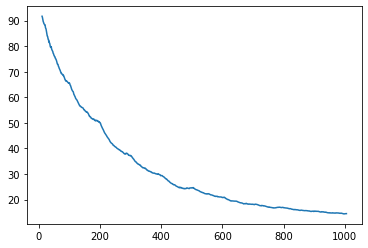

In [28]:
learn.sched.plot_loss()

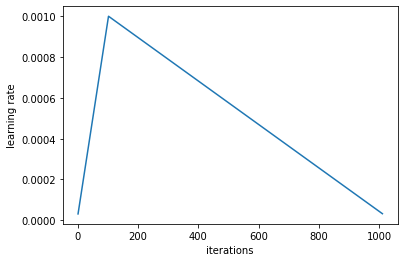

In [29]:
learn.sched.plot_lr()

# Visualize results of the training

In [30]:
y = learn.predict()
x,_ = next(iter(md_box.val_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AM General Hummer SUV 2000
AM General Hummer SUV 2000
AM General Hummer SUV 2000
AM General Hummer SUV 2000
AM General Hummer SUV 2000
AM General Hummer SUV 2000
AM General Hummer SUV 2000
AM General Hummer SUV 2000
Hyundai Santa Fe SUV 2012
Ford Expedition EL SUV 2009
GMC Savana Van 2012
Chevrolet Express Van 2007


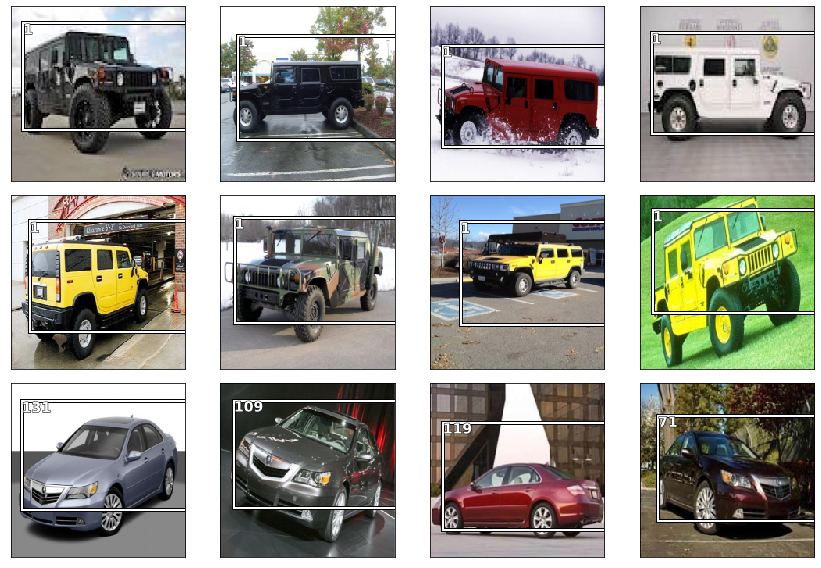

In [33]:

x,_ = next(iter(md_box.val_dl))
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md_box.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb
    c = np.argmax(y[i][4:]) + 1
    print(car_classes.loc[c]['model'])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], c)
plt.tight_layout()